# Perform benchmark on dyngen simulated datasets

## Import library

In [1]:
import tensorflow
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv

from scipy.spatial.distance import cdist
import pandas as pd
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from distributed import Client, LocalCluster
import sklearn
import scipy.stats as stats
from typing import Literal
import anndata
import scipy
import matplotlib.pyplot as plt
## define function
import torch

from regvelovi import REGVELOVI
from typing import Literal
from velovi import preprocess_data, VELOVI
import anndata

from scipy.spatial.distance import cdist
import pandas as pd
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
from distributed import Client, LocalCluster
import sklearn
import scipy.stats as stats
import seaborn as sns

from sklearn.mixture import GaussianMixture
from scvelo import logging as logg
import math
import random
import torch.nn.functional as F

from matplotlib import pyplot as plt
import seaborn as sns
import mplscience
from scipy.stats import ttest_rel
from scipy.stats import pearsonr, spearmanr, ttest_ind,wilcoxon

2024-08-09 23:39:42.058112: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 23:39:45.261805: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 23:39:45.262486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 23:39:45.268828: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 23:39:46.361162: I tensorflow/core/platform/cpu_feature_g

In [2]:
import sys
import os
import unitvelo as utv
sys.path.append(os.getcwd() + "/RegVelo_datasets/VeloVAE")
import velovae as vv

(Running UniTVelo 0.2.5.2)
2024-08-09 21:43:31


In [3]:
from paths import FIG_DIR, DATA_DIR

## General setting

In [4]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map='viridis')

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

In [6]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'simulation' / 'dyngen_results',exist_ok = True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / 'simulation' / 'dyngen_results',exist_ok = True)
    os.makedirs(DATA_DIR / 'simulation' / 'dyngen_results' / 'copy_file',exist_ok = True)

## Define function

In [7]:
def csgn_groundtruth(adata):
    csgn_array = adata.obsm["regulatory_network_sc"].toarray()
    csgn_tensor = torch.zeros([len(adata.uns["regulators"]),len(adata.uns["targets"]),csgn_array.shape[0]])
    
    for k in range(csgn_array.shape[0]):
        ## generate a 3D tensor to indicate the ground truth network for each cell
        grnboost_m = np.zeros((len(adata.uns["regulators"]),len(adata.uns["targets"])))
        grnboost_m = pd.DataFrame(grnboost_m,index = adata.uns["regulators"], columns = adata.uns["targets"])
        for i in range(adata.uns["regulatory_network"].shape[0]):
            #ind = (adata.uns["regulatory_network"]["regulator"] == j) & (adata.uns["regulatory_network"]["target"] == i)
            regulator = adata.uns["regulatory_network"].iloc[i]["regulator"]
            target = adata.uns["regulatory_network"].iloc[i]["target"]
            grnboost_m.loc[regulator,target] = csgn_array[k,i]
        tensor = torch.tensor(np.array(grnboost_m))
        csgn_tensor[:,:,k] = tensor
        
    return csgn_tensor

def csgn_benchmark(GRN,csgn):
    csgn[csgn!=0] = 1
    if len(GRN.shape)>2:
        print("Input is cell type specific GRN...")
        score = []
        for i in range(csgn.shape[2]):
            W = csgn[:,:,i]
            W[W!=0] = 1
            #auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(GRN[:,:,i].numpy().ravel()))
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = GRN[:,:,i].numpy().ravel(), pos_label = 1) #positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            score.append(auroc)
    else:
        print("Input is global GRN...")
        score = []
        for i in range(csgn.shape[2]):
            W = csgn[:,:,i]
            W[W!=0] = 1
            #auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(GRN.numpy().ravel()))
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = W.T.ravel(), y_score = GRN.numpy().ravel(), pos_label = 1) #positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            score.append(auroc)
    return score


def csgn_benchmark2(GRN,W,csgn):
    csgn[csgn!=0] = 1
    if len(GRN.shape)>2:
        print("Input is cell type specific GRN...")
        score = []
        for i in range(csgn.shape[2]):
            net = csgn[:,:,i]
            #auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(GRN[:,:,i].numpy().ravel()))
            pre = GRN[:,:,i][np.array(W.T)==1]
            gt = net.T[np.array(W.T)==1]
            gt[gt!=0] = 1
            
            number = min(10000,len(gt))
            pre,index = torch.topk(pre,number)
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = gt[index], y_score = pre, pos_label = 1) #positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            score.append(auroc)
    else:
        print("Input is global GRN...")
        score = []
        for i in range(csgn.shape[2]):
            net = csgn[:,:,i]
            pre = GRN[np.array(W.T)==1]
            gt = net.T[np.array(W.T)==1]
            gt[gt!=0] = 1
            
            number = min(10000,len(gt))
            pre,index = torch.topk(pre,number)
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = gt[index], y_score = pre, pos_label = 1) #positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            score.append(auroc)
    return score

def sanity_check(
       adata,
       network_mode: Literal["GENIE3","full_ODE"] = "GENIE3",
    ) -> anndata.AnnData:
    
    if network_mode == "GENIE3":
        reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
        tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
        adata.uns["regulators"] = adata.uns["regulators"][reg_index]
        adata.uns["targets"] = adata.uns["targets"][tar_index]
        W = adata.uns["skeleton"]
        W = W[reg_index,:]
        W = W[:,tar_index]
        adata.uns["skeleton"] = W
        W = adata.uns["network"]
        W = W[reg_index,:]
        W = W[:,tar_index]
        adata.uns["network"] = W   
        regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
        targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]     
        adata = adata[:,np.unique(regulators.tolist()+targets.tolist())].copy()     
        ## to make sure consistency
        regulator_index = [i in regulators for i in adata.var.index.values]
        target_index = [i in targets for i in adata.var.index.values]
        regulators = adata.var.index.values[regulator_index]
        targets = adata.var.index.values[target_index]
        print("num regulators: "+str(len(regulators)))
        print("num targets: "+str(len(targets)))      
        W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
        W = W.loc[regulators,targets]
        adata.uns["skeleton"] = W
        W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
        W = W.loc[regulators,targets]
        adata.uns["network"] = W     
        adata.uns["regulators"] = regulators
        adata.uns["targets"] = targets
    if network_mode == "full_ODE":
        ## filter the gene first
        csgn = adata.uns["csgn"]
        gene_name = adata.var.index.tolist()
        full_name = adata.uns["regulators"]
        index = [i in gene_name for i in full_name]
        full_name = full_name[index]
        adata = adata[:,full_name].copy()
        W = adata.uns["skeleton"]
        W = W[index,:]
        W = W[:,index]
        adata.uns["skeleton"] = W 
        W = adata.uns["network"]
        W = W[index,:]
        W = W[:,index]
        csgn = csgn[index,:,:]
        csgn = csgn[:,index,:]
        adata.uns["network"] = W
        ###
        W = adata.uns["skeleton"]
        gene_name = adata.var.index.tolist()
        indicator = W.sum(0) > 0 ## every gene would need to have a upstream regulators
        regulators = [gene for gene, boolean in zip(gene_name, indicator) if boolean]
        targets = [gene for gene, boolean in zip(gene_name, indicator) if boolean]
        print("num regulators: "+str(len(regulators)))
        print("num targets: "+str(len(targets)))
        W = adata.uns["skeleton"]
        W = W[indicator,:]
        W = W[:,indicator]
        adata.uns["skeleton"] = W
        W = adata.uns["network"]
        W = W[indicator,:]
        W = W[:,indicator]
        adata.uns["network"] = W
        csgn = csgn[indicator,:,:]
        csgn = csgn[:,indicator,:]
        adata.uns["csgn"] = csgn
        adata.uns["regulators"] = regulators
        adata.uns["targets"] = targets
        W = pd.DataFrame(adata.uns["skeleton"],index = adata.uns["regulators"],columns = adata.uns["targets"])
        W = W.loc[regulators,targets]
        adata.uns["skeleton"] = W
        W = pd.DataFrame(adata.uns["network"],index = adata.uns["regulators"],columns = adata.uns["targets"])
        W = W.loc[regulators,targets]
        adata.uns["network"] = W
        adata = adata[:,indicator].copy()
        adata.obsm["knn"] = adata.uns["neighbors"]["indices"].copy()
    return adata

def add_velovi_outputs_to_adata(adata, vae):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: fit_velovi() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/model_fit.ipynb
    # License: BSD-3-Clause license

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")
    t = latent_time
    scaling = 20 / t.max(0)
    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time
    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t_velovi"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0
    
def add_noise_graph(W, noise_level = 0.2):
    W_c = 1 - W
    edge = torch.nonzero(W)
    ## drop edge
    num_edge = edge.shape[0]
    selected_numbers = random.sample(range(edge.shape[0]), math.ceil( (1 - noise_level) * num_edge))
    edge = edge[selected_numbers,:]
    #
    edge_c = torch.nonzero(W_c)
    ## select noise edge
    selected_numbers = random.sample(range(edge_c.shape[0]), math.ceil( (noise_level) * num_edge))
    edge_c = edge_c[selected_numbers,:]
    ### generate final edge
    edge = torch.cat([edge,edge_c],0)
    ## generate disturbed graph
    binary_tensor = torch.zeros(W.shape)
    binary_tensor[edge[:, 0], edge[:, 1]] = 1
    return binary_tensor

    
def add_regvelo_outputs_to_adata(adata_raw, vae):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: fit_velovi() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/model_fit.ipynb
    # License: BSD-3-Clause license

    latent_time = vae.get_latent_time(n_samples=25, time_statistic = "mean")
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:,vae.module.target_index].copy()
    
    adata.layers["velocity"] = velocities / scaling
    #adata.layers["velocity"] = velocities
    adata.layers["latent_time_regvelo"] = latent_time
    
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    #adata.layers["fit_t"] = latent_time.values
    adata.var['fit_scaling'] = 1.0
    
    #adata.obs["latent_time"] = vae.compute_shared_time(adata.layers["fit_t"])
    return adata

def GRN_Jacobian(reg_vae,Ms):
    net = reg_vae.module.v_encoder.fc1.weight.detach()
    bias = reg_vae.module.v_encoder.fc1.bias.detach() 
    max_rate = reg_vae.module.v_encoder.alpha_unconstr_max.detach()
    ## calculate the jacobian matrix respect to each cell
    Jaco_m = []
    for i in range(Ms.shape[0]):
        s = Ms[i,:]
        ## calculate sigmoid probability
        #alpha_unconstr = torch.matmul(net,torch.tensor(s[reg_vae.module.v_encoder.regulator_index]))
        #alpha_unconstr = alpha_unconstr + bias
        #alpha_unconstr = reg_vae.module.v_encoder.fc1(torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")).detach()
        #coef = (F.sigmoid(alpha_unconstr))
        #alpha_max = torch.clamp(F.softplus(max_rate),0,50)
        #Jaco_m.append(torch.matmul(torch.diag(coef), net))
        Jaco_m.append(reg_vae.module.v_encoder.GRN_Jacobian(torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")).detach())
    Jaco_m = torch.stack(Jaco_m,2)
    return Jaco_m

def calculate_sign_ratio(vector1, vector2):
    if len(vector1) != len(vector2):
        raise ValueError("Both vectors must have the same length.")
    same_sign_count = 0
    total_count = 0
    for sign1, sign2 in zip(vector1, vector2):
        if sign1 != 0 and sign2 != 0:
            if sign1 == sign2:
                same_sign_count += 1
            total_count += 1
    if total_count == 0:
        return 0.0
    return same_sign_count / total_count

In [8]:
def get_significance(pvalue):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: get_significance() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/fucci.ipynb
    # License: BSD-3-Clause license
    
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

def add_significance2(ax, bottom: int, top: int, significance: str, level: int = 0, **kwargs):
    # This code is adapted on an implementation by Adam Gayoso, Philipp Weilier and Justing Hong from their repository:
    # https://github.com/YosefLab/velovi_reproducibility
    # Original function: add_significance() in https://github.com/YosefLab/velovi_reproducibility/blob/main/notebooks/estimation_comparison/fucci.ipynb
    # License: BSD-3-Clause license

    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    left, right = ax.get_xlim()
    x_axis_range = right - left

    bracket_level = (x_axis_range * 0.07 * level) + right * bracket_level
    bracket_height = bracket_level - (x_axis_range * bracket_height)
    
    ax.plot(
        [bracket_height, bracket_level, bracket_level, bracket_height],
        [bottom, bottom, top, top], **kwargs
    )

    ax.text(
        bracket_level + (x_axis_range * text_height),
        (bottom + top) * 0.5,
        significance,
        va='center',
        ha='left',
        c='k',
        rotation=90
    )

## Import dataset

In [9]:
time_corr_all = list()
gene_time_corr_all = list()
gene_velo_corr_all = list()
AUC_GRN_result = list()
AUC_GRN_result_all = list()

# Define the path of the folder you want to check
folder_path = os.getcwd() + '/RegVelo_datasets/dyngen_simulation/'
# Get a list of all files in the folder
files = os.listdir(folder_path)
files = [file for file in files if file.endswith(".h5ad")]

## Running Benchmark

Filtered out 1 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 74
num targets: 74
recovering dynamics (using 1/112 cores)


  0%|          | 0/74 [00:00<?, ?gene/s]

    finished (0:00:04) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/112 cores)


  0%|          | 0/300 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 23.83it/s, loss=-267, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 19.79it/s, loss=-267, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1115/1500:  74%|███████▍  | 1115/1500 [05:20<01:50,  3.48it/s, loss=-169, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -273.603. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Extracted 74 highly variable genes.
Computing moments for 74 genes with n_neighbors: 30 and n_pcs: 30
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/sp

Loss (Total): 59673.792, (Spliced): 31813.844, (Unspliced): 27859.948:  90%|████████▉ | 10791/12000 [02:04<00:15, 78.83it/s]  

*********       Stage 1: Early Stop Triggered at epoch 770.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.060
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1099.    *********
Change in noise variance: 0.3093
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1185.    *********
Change in noise variance: 0.0305
Change in x0: 0.9398
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1272.    *********
Change in noise variance: 0.0450
Change in x0: 0.5792
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1283.    *********
Change in noise variance: 0.0110
Change in x0: 0.4535
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1348.    *********
Change in noise variance: 0.0093
Change in x0: 0.3768
*********             Velocity Refinement Round 

  0%|          | 0/74 [00:00<?, ?it/s]

Detected 24 velocity genes.
Estimating the variance...


  0%|          | 0/74 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/74 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [2. 1. 2.]
Initial induction: 31, repression: 43/74
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 804.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.077
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 810.    *********
Change in noise variance: 0.3238
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 816.    *********
Change in noise variance: 0.1014
Change in x0: 1.3979
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 932.    *********
Change in noise variance: 0.0224
Change in x0: 0.8053
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 938.    *********
Change in noise variance: 0.0273
Change in x0: 0.5553
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 943.    *********
Change in noise variance: 0.0058
Change in x0: 0.4277
*********             Velocity Refinement Round 6    

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8506188313775961, 0.698132526569513, 0.544157083965864, 0.4287325695408479, 0.5314312298434365]
[0.8301379394704402, 0.7656954728176608, 0.6961849315335934, 0.7536910071344153, 0.7643794628725404]
Done dataset_sim24.h5ad!
num regulators: 53
num targets: 53


  0%|          | 0/53 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 21.12it/s, loss=-170, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.40it/s, loss=-170, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 530/1500:  35%|███▌      | 530/1500 [02:35<05:25,  2.98it/s, loss=-45.3, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1106/1500:  74%|███████▎  | 1106/1500 [05:39<02:01,  3.26it/s, loss=-93.1, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -176.766. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 53 highly variable genes.
Computing moments for 53 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 21 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 21 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 21 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 2295.357, (Spliced): 1065.523, (Unspliced): 1229.834:  28%|██▊       | 3377/12000 [00:35<01:17, 111.78it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 2155.285, (Spliced): 1146.126, (Unspliced): 1009.158: 100%|█████████▉| 11993/12000 [02:22<00:00, 68.43it/s]

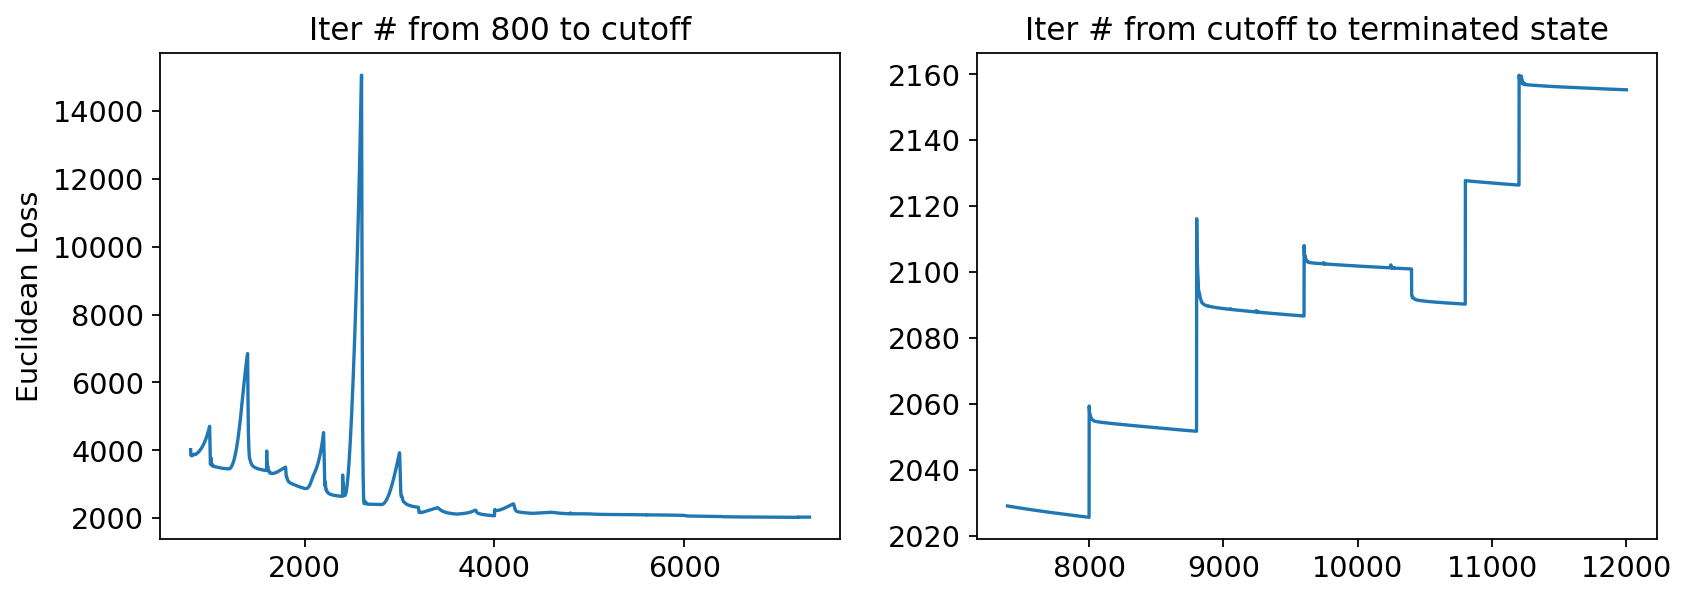

Loss (Total): 2155.285, (Spliced): 1146.126, (Unspliced): 1009.158: 100%|█████████▉| 11999/12000 [02:22<00:00, 84.18it/s]

Total loss 2025.543, vgene loss 2155.285


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/53 [00:00<?, ?it/s]

Detected 20 velocity genes.
Estimating the variance...


  0%|          | 0/53 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/53 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 1 to repressive
Initial induction: 38, repression: 15/53
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 741.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 747.    *********
Change in noise variance: 0.4387
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 943.    *********
Change in noise variance: 0.0617
Change in x0: 0.6784
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 992.    *********
Change in noise variance: 0.1028
Change in x0: 0.3961
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 997.    *********
Change in noise variance: 0.0368
Change in x0: 0.3220
*********             Velocity Refinement Round 5             *********
*********       Stage 1: Early Stop Triggered at epoch 747.       *********
*********                      Stage  2                       *********
*********             Velocity

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 874.    *********
Change in noise variance: 0.4279
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 979.    *********
Change in noise variance: 0.0388
Change in x0: 0.5292
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1023.    *********
Change in noise variance: 0.0020
Change in x0: 0.4171
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1036.    *********
Change in noise variance: 0.0021
Change in x0: 0.3211
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1063.    *********
Change in noise variance: 0.0012
Change in x0: 0.2315
*********             Velocity Refinement Round 6 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8573807148999947, 0.7147820750537021, 0.5698928157019834, 0.4849166069268362, 0.5253908479364979]
[0.8350706386741908, 0.7572884768261747, 0.6765395303629318, 0.6878905959003248, 0.6924907712799486]
Done dataset_sim20.h5ad!
num regulators: 78
num targets: 78


  0%|          | 0/78 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.17it/s, loss=-279, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.17it/s, loss=-279, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1356/1500:  90%|█████████ | 1356/1500 [06:56<00:44,  3.25it/s, loss=-177, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -272.545. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 78 highly variable genes.
Computing moments for 78 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 31 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 31 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 31 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 788.261, (Spliced): 391.774, (Unspliced): 396.487: 100%|█████████▉| 11994/12000 [02:26<00:00, 68.52it/s]    

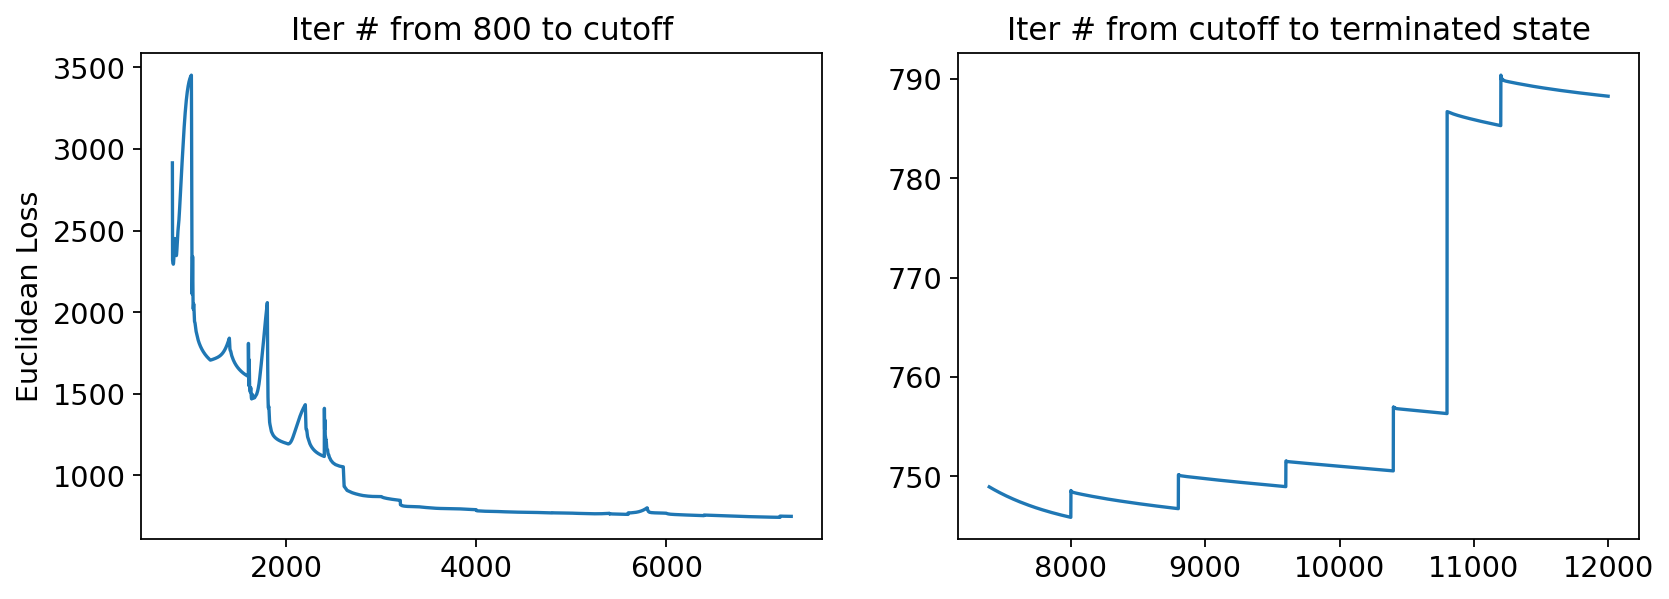

Loss (Total): 788.261, (Spliced): 391.774, (Unspliced): 396.487: 100%|█████████▉| 11999/12000 [02:26<00:00, 81.66it/s]

Total loss 745.879, vgene loss 788.261


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/78 [00:00<?, ?it/s]

Detected 29 velocity genes.
Estimating the variance...


  0%|          | 0/78 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/78 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.67, 0.41183800731803566), (0.33, 0.8783041582490457)
(0.56, 0.24885817321857973), (0.44, 0.8018410694412413)
(0.55, 0.8397927480631289), (0.45, 0.29592479722300924)
KS-test result: [0. 0. 0.]
Initial induction: 36, repression: 42/78
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 694.       *******

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.010
Average Set Size: 16
Change in noise variance: 0.6179
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1220.    *********
Change in noise variance: 0.1674
Change in x0: 0.8839
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1236.    *********
Change in noise variance: 0.0177
Change in x0: 0.4047
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1243.    *********
Change in noise variance: 0.0047
Change in x0: 0.2219
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1255.    *********
Change in noise variance: 0.0036
Change in x0: 0.1674
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at e

  0%|          | 0/78 [00:00<?, ?it/s]

Detected 31 velocity genes.
Estimating the variance...


  0%|          | 0/78 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/78 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.68, 0.31404874395166643), (0.32, 0.8728158988292871)
KS-test result: [1. 0. 1.]
Initial induction: 53, repression: 25/78
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 18
*********     Round 1: Early Stop Triggered at epoch 1069.    *********
Change in noise variance: 0.5922
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1137.    *********
Change in noise variance: 0.0460
Change in x0: 0.5976
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1182.    *********
Change in noise variance: 0.0006
Change in x0: 0.3396
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1187.    *********
Change in noise variance: 0.0000
Change in x0: 0.2579
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1200.    *********
Change in noise variance: 0.0000
Change in x0: 0.2272
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8451434213308232, 0.6302259509699324, 0.5288842666126224, 0.3877956737835768, 0.5026045602687903]
[0.7758495104833861, 0.6526150887421477, 0.5762184779013397, 0.7458900568877607, 0.7479502667348735]
Done dataset_sim39.h5ad!
num regulators: 57
num targets: 57


  0%|          | 0/57 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 22.65it/s, loss=-179, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 22.30it/s, loss=-179, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 59/1500:   4%|▍         | 58/1500 [00:08<03:46,  6.35it/s, loss=156, v_num=1]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 920/1500:  61%|██████▏   | 920/1500 [04:32<02:51,  3.38it/s, loss=-80.2, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -164.826. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 57 highly variable genes.
Computing moments for 57 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 22 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 20 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 20 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 917411379.200, (Spliced): 442334873.600, (Unspliced): 475076505.600:  95%|█████████▌| 11402/12000 [02:13<00:08, 70.06it/s]   IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1074/1500:  72%|███████▏  | 1074/1500 [05:31<02:11,  3.24it/s, loss=-178, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -283.196. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 78 highly variable genes.
Computing moments for 78 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 23 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 23 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 23 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 29288.947, (Spliced): 15961.341, (Unspliced): 13327.606:  80%|████████  | 9600/12000 [01:51<00:30, 79.90it/s]  

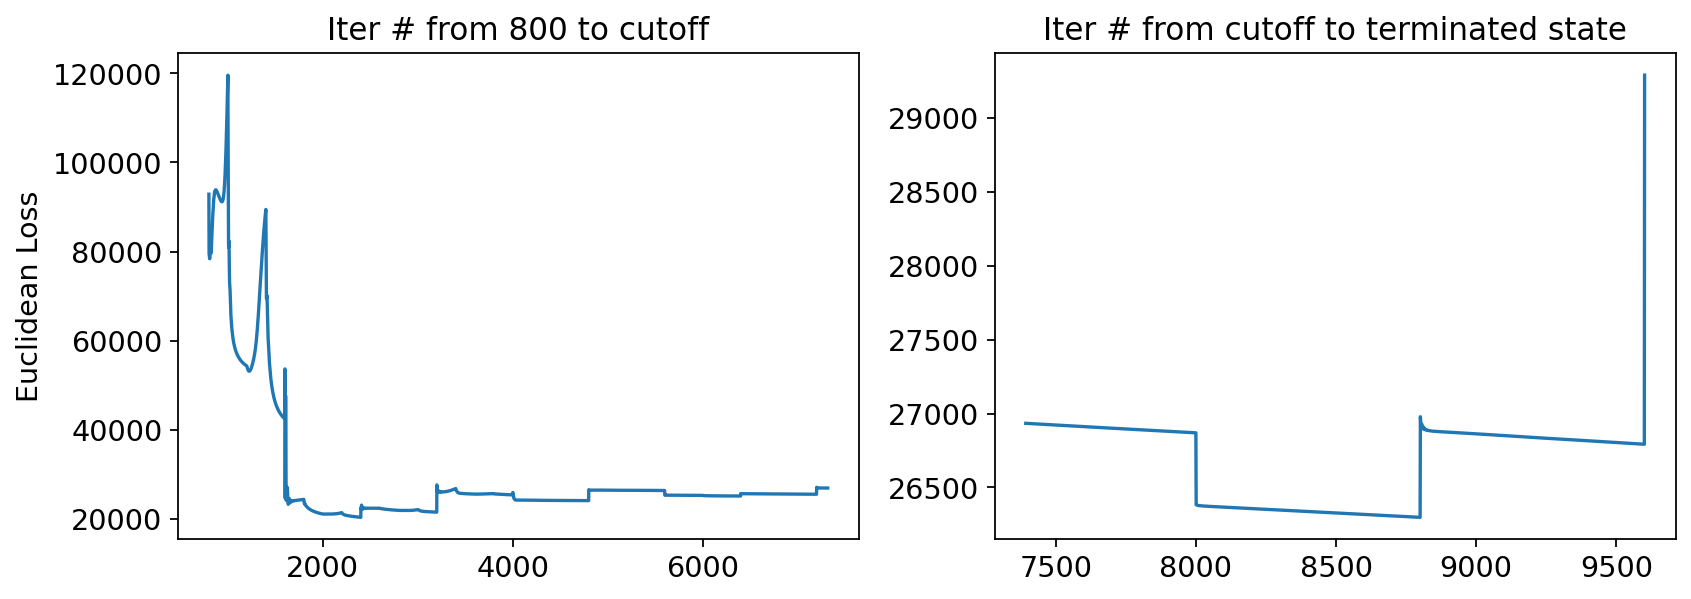

Loss (Total): 29288.947, (Spliced): 15961.341, (Unspliced): 13327.606:  80%|████████  | 9601/12000 [01:51<00:27, 85.96it/s]

Total loss 26297.664, vgene loss 29288.947


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/78 [00:00<?, ?it/s]

Detected 25 velocity genes.
Estimating the variance...


  0%|          | 0/78 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/78 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
*********       Stage 1: Early Stop Triggered at epoch 791.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.043
Average Set Size: 19
Change in noise variance: 0.6635
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1374.    *********
Change in noise variance: 0.0609
Change in x0: 0.7135
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1439.    *********
Change in noise variance: 0.0032
Change in x0: 0.4339
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1562.    *********
Change in noise variance: 0.0033
Change in x0: 0.3757
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1667.    *********
Change in noise variance: 0.0042
Change in x0: 0.4171
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at e

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7906011039653383, 0.5946843939186237, 0.5652567619974315, 0.3855469185441177, 0.5107130608324956]
[0.7816070988466004, 0.7043377825025404, 0.7197269516434442, 0.7033436395997057, 0.7557762058393268]
Done dataset_sim18.h5ad!
num regulators: 70
num targets: 70


  0%|          | 0/70 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 23.06it/s, loss=-204, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.46it/s, loss=-204, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1152/1500:  77%|███████▋  | 1152/1500 [06:13<01:52,  3.08it/s, loss=-130, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -208.336. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 68 highly variable genes.
Computing moments for 68 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 33 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 33 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 33 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 323.571, (Spliced): 160.452, (Unspliced): 163.119:  73%|███████▎  | 8780/12000 [01:41<00:43, 73.68it/s]  

*********       Stage 1: Early Stop Triggered at epoch 477.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 483.    *********
Change in noise variance: 0.3667
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 659.    *********
Change in noise variance: 0.0644
Change in x0: 0.7377
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 664.    *********
Change in noise variance: 0.0031
Change in x0: 0.3748
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 670.    *********
Change in noise variance: 0.0030
Change in x0: 0.3185
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 675.    *********
Change in noise variance: 0.0012
Change in x0: 0.2702
*********             Velocity Refinement Round 6    

  0%|          | 0/68 [00:00<?, ?it/s]

Detected 32 velocity genes.
Estimating the variance...


  0%|          | 0/68 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/68 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 1 to repressive
Initial induction: 46, repression: 22/68
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 666.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.037
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 678.    *********
Change in noise variance: 0.3559
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 690.    *********
Change in noise variance: 0.0263
Change in x0: 0.6446
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 696.    *********
Change in noise variance: 0.0033
Change in x0: 0.4315
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 718.    *********
Change in noise variance: 0.0021
Change in x0: 0.3458
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 724.    *********
Change in noise variance: 0.0005
Change in x0: 0.3028
*********             Velocity Refinement Round 6    

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7184732549126921, 0.6237152833871366, 0.6317155308126672, 0.44807183527453354, 0.5638736707815201]
[0.7382686834698727, 0.7479381509067393, 0.7618353237858023, 0.7381249632144276, 0.7515360105590837]
Done dataset_sim8.h5ad!
num regulators: 71
num targets: 71


  0%|          | 0/71 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 18.29it/s, loss=-236, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 20.00it/s, loss=-236, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1422/1500:  95%|█████████▍| 1422/1500 [07:03<00:23,  3.36it/s, loss=-160, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -263.068. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 71 highly variable genes.
Computing moments for 71 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 23 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 22 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 22 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 2055764061.091, (Spliced): 944324049.455, (Unspliced): 1111440011.636:  17%|█▋        | 2074/12000 [00:21<01:46, 93.56it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 49829.149, (Spliced): 27279.365, (Unspliced): 22549.784: 100%|█████████▉| 11992/12000 [02:22<00:00, 71.61it/s]

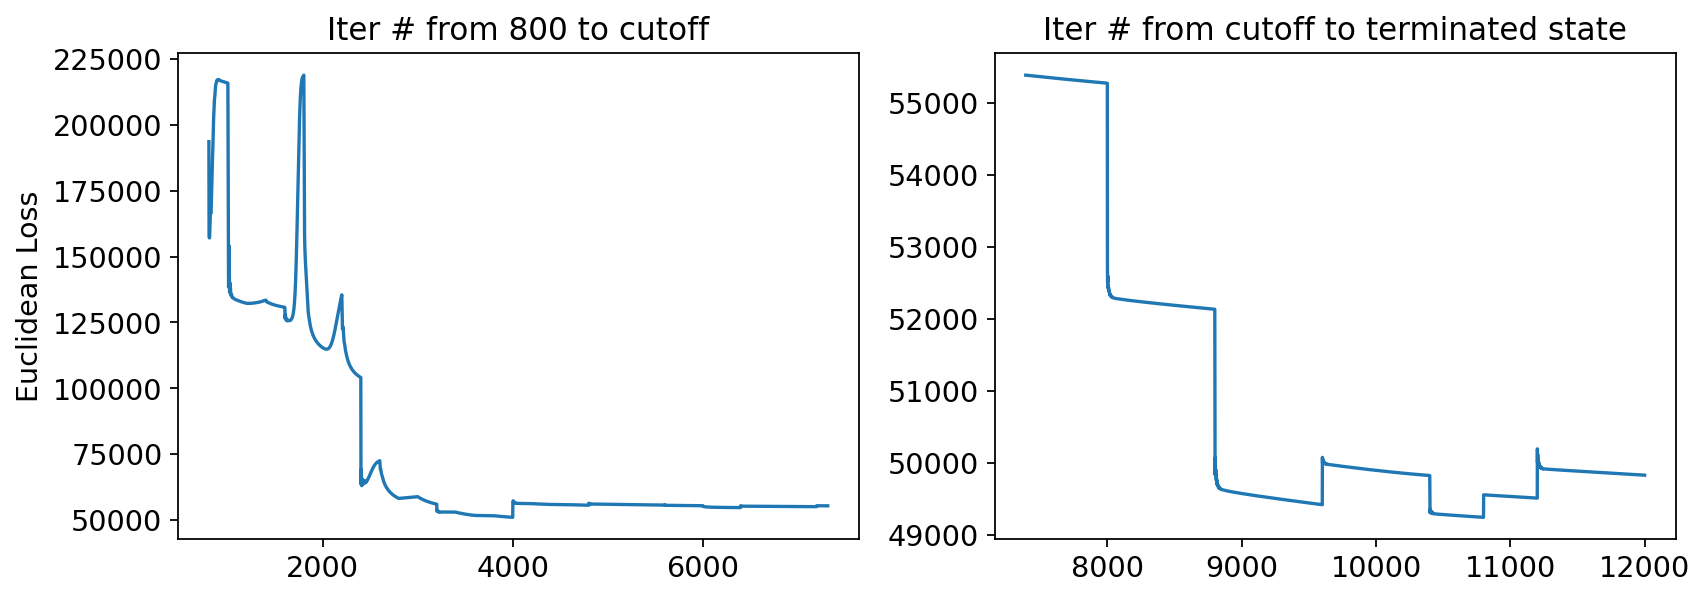

Loss (Total): 49829.149, (Spliced): 27279.365, (Unspliced): 22549.784: 100%|█████████▉| 11999/12000 [02:23<00:00, 83.70it/s]

Total loss 49244.062, vgene loss 49829.149


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/79 [00:00<?, ?it/s]

Detected 29 velocity genes.
Estimating the variance...


  0%|          | 0/79 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/79 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.56, 0.9403346451845439), (0.44, 0.32314691237421145)
(0.48, 0.8345042476253662), (0.52, 0.3134500050535354)
(0.61, 0.24412479222398134), (0.39, 0.9298455167985337)
KS-test result: [0. 0. 0.]
Initial induction: 35, repression: 44/79
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
**

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 15
Change in noise variance: 0.2818
*********             Velocity Refinement Round 2             *********
*********     Round 3: Early Stop Triggered at epoch 1696.    *********
Change in noise variance: 0.0041
Change in x0: 0.3199
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1729.    *********
Change in noise variance: 0.0017
Change in x0: 0.2335
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1761.    *********
Change in noise variance: 0.0005
Change in x0: 0.2038
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at epoch 1769.    *********
Change in noise variance: 0.0000
Change in x0: 0.1776
*********             Velocity Refinement Round 7             *********
*********     Round 7: Early Stop Triggered at e

  0%|          | 0/79 [00:00<?, ?it/s]

Detected 29 velocity genes.
Estimating the variance...


  0%|          | 0/79 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/79 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.58, 0.8115811156996988), (0.42, 0.27576026755696786)
(0.57, 0.8772142387483798), (0.43, 0.1968760262706289)
KS-test result: [1. 0. 0.]
Initial induction: 55, repression: 24/79
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1         

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.047
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1045.    *********
Change in noise variance: 0.2699
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1324.    *********
Change in noise variance: 0.0239
Change in x0: 0.7024
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1543.    *********
Change in noise variance: 0.0193
Change in x0: 0.4442
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1563.    *********
Change in noise variance: 0.0015
Change in x0: 0.2967
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1607.    *********
Change in noise variance: 0.0017
Change in x0: 0.2480
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8062581475141378, 0.6624792860469085, 0.5932958668681497, 0.3754503002900978, 0.5017766663067058]
[0.8111287922795544, 0.7623322554785752, 0.7694431817383941, 0.7167213864478652, 0.7649647359317971]
Done dataset_sim12.h5ad!
num regulators: 46
num targets: 46


  0%|          | 0/46 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 22.72it/s, loss=-113, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.71it/s, loss=-113, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1141/1500:  76%|███████▌  | 1141/1500 [05:59<01:53,  3.17it/s, loss=-68.7, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -141.709. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 46 highly variable genes.
Computing moments for 46 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 25 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 25 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 25 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 940.240, (Spliced): 559.836, (Unspliced): 380.405: 100%|█████████▉| 11996/12000 [02:20<00:00, 60.69it/s]    

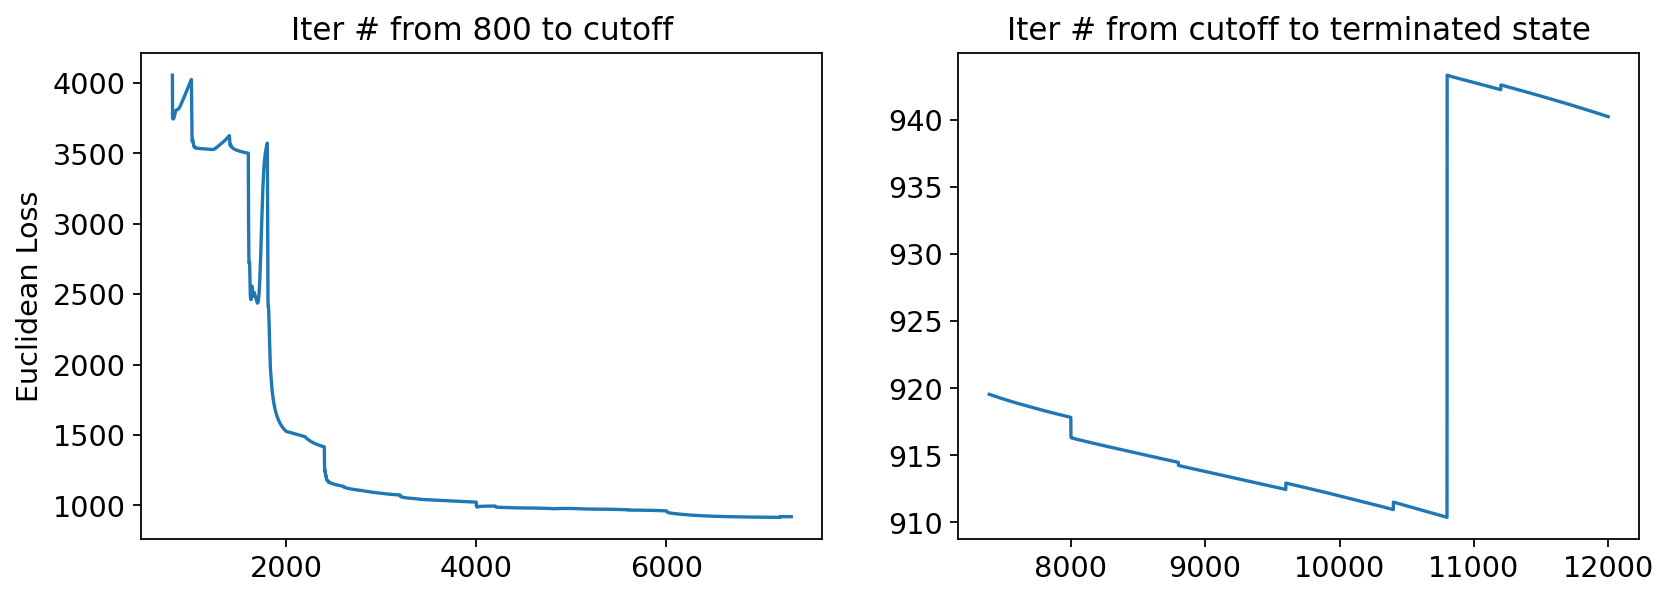

Loss (Total): 940.240, (Spliced): 559.836, (Unspliced): 380.405: 100%|█████████▉| 11999/12000 [02:20<00:00, 85.17it/s]

Total loss 910.383, vgene loss 940.240


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/46 [00:00<?, ?it/s]

Detected 24 velocity genes.
Estimating the variance...


  0%|          | 0/46 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/46 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.43, 0.28576978576761086), (0.57, 0.9104735568477832)
KS-test result: [1. 1. 0.]
Initial induction: 36, repression: 10/46
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 511.       *********
*********                      Stage  2                       *********
*********             Velocity Refine

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 517.    *********
Change in noise variance: 0.6378
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 536.    *********
Change in noise variance: 0.0487
Change in x0: 0.3848
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 597.    *********
Change in noise variance: 0.0025
Change in x0: 0.2893
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 626.    *********
Change in noise variance: 0.0025
Change in x0: 0.2229
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 632.    *********
Change in noise variance: 0.0017
Change in x0: 0.1844
*********             Velocity Refinement Round 6    

  0%|          | 0/46 [00:00<?, ?it/s]

Detected 23 velocity genes.
Estimating the variance...


  0%|          | 0/46 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/46 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 0 to repressive
Initial induction: 35, repression: 11/46
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.3598
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0124
Change in x0: 0.5209
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1067.    *********
Change in noise variance: 0.0008
Change in x0: 0.3891
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1074.    *********
Change in noise variance: 0.0000
Change in x0: 0.2885
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1097.    *********
Change in noise variance: 0.0000
Change in x0: 0.2461
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7744541367819017, 0.5813255268207748, 0.45917147613034975, 0.32977408042531847, 0.41474877607584365]
[0.7140658259753039, 0.6234564461620771, 0.5447057755852772, 0.6422706710101839, 0.6565577169698574]
Done dataset_sim22.h5ad!
num regulators: 73
num targets: 73


  0%|          | 0/73 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.34it/s, loss=-244, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.17it/s, loss=-244, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 334/1500:  22%|██▏       | 333/1500 [01:27<06:30,  2.99it/s, loss=-23.1, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1213/1500:  81%|████████  | 1213/1500 [05:53<01:23,  3.43it/s, loss=-144, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -238.008. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 73 highly variable genes.
Computing moments for 73 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 31 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 31 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 31 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 1080.732, (Spliced): 534.591, (Unspliced): 546.141:  20%|██        | 2431/12000 [00:25<01:44, 91.31it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 530.371, (Spliced): 252.594, (Unspliced): 277.778:  90%|████████▉ | 10797/12000 [02:03<00:15, 76.93it/s]

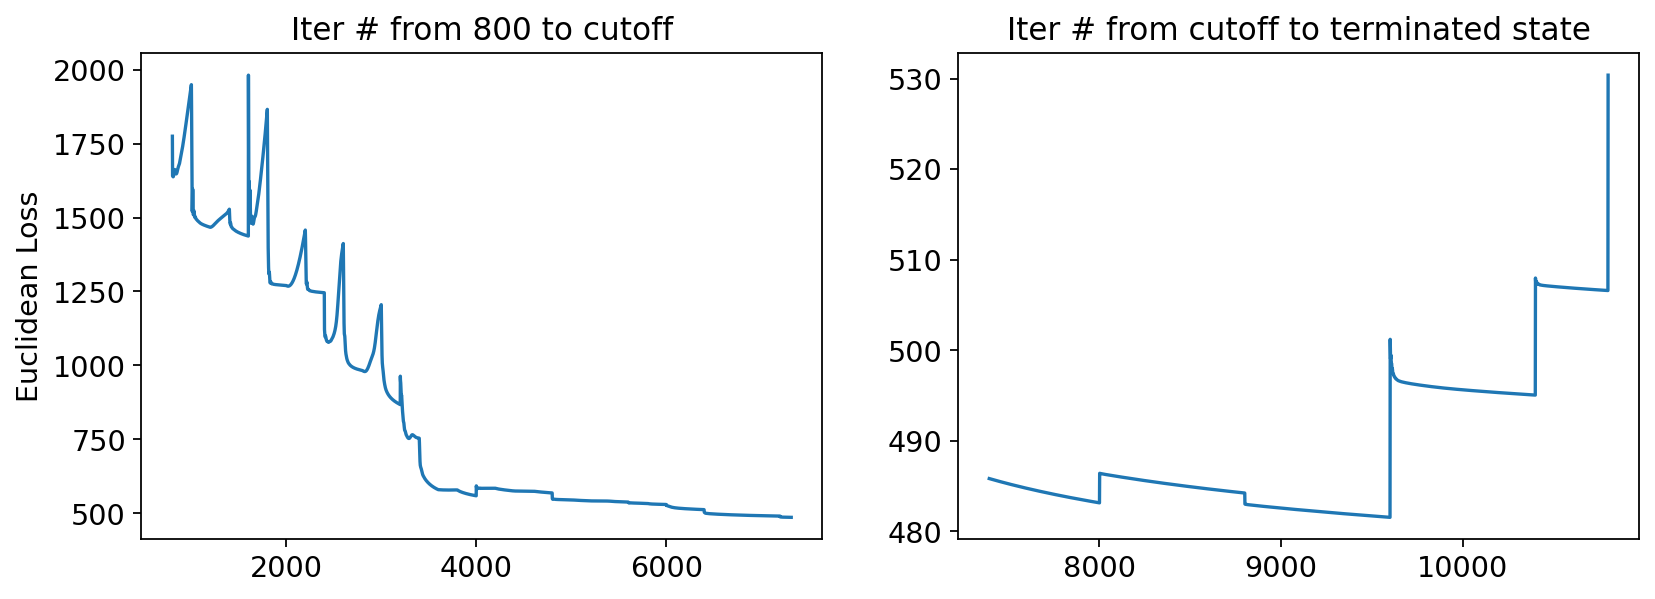

Loss (Total): 530.371, (Spliced): 252.594, (Unspliced): 277.778:  90%|█████████ | 10801/12000 [02:04<00:13, 86.94it/s]

Total loss 481.563, vgene loss 530.371


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/73 [00:00<?, ?it/s]

Detected 29 velocity genes.
Estimating the variance...


  0%|          | 0/73 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/73 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 1 to repressive
Initial induction: 52, repression: 21/73
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.020
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1324.    *********
Change in noise variance: 0.3800
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1373.    *********
Change in noise variance: 0.0043
Change in x0: 1.4158
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1546.    *********
Change in noise variance: 0.0063
Change in x0: 0.8424
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1657.    *********
Change in noise variance: 0.0116
Change in x0: 0.4697
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1791.    *********
Change in noise variance: 0.0263
Change in x0: 0.3412
*********             Velocity Refinement Round 

  0%|          | 0/73 [00:00<?, ?it/s]

Detected 31 velocity genes.
Estimating the variance...


  0%|          | 0/73 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/73 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 0 to repressive
Initial induction: 41, repression: 32/73
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 682.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 15
Change in noise variance: 0.4306
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1232.    *********
Change in noise variance: 0.1056
Change in x0: 0.7333
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1291.    *********
Change in noise variance: 0.0088
Change in x0: 0.3148
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1334.    *********
Change in noise variance: 0.0026
Change in x0: 0.1793
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1339.    *********
Change in noise variance: 0.0019
Change in x0: 0.1465
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at e

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8224954032169443, 0.6104429811544608, 0.5099344700555681, 0.368096027613699, 0.49370086104057065]
[0.7530529388626718, 0.6247176511493645, 0.5712176920993491, 0.7296614102919352, 0.7552257024728454]
Done dataset_sim41.h5ad!
num regulators: 75
num targets: 75


  0%|          | 0/75 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 490/500:  98%|█████████▊| 490/500 [00:24<00:00, 20.15it/s, loss=-217, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -230.292. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1283/1500:  86%|████████▌ | 1283/1500 [06:28<01:05,  3.30it/s, loss=-152, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -251.310. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 75 highly variable genes.
Computing moments for 75 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 37 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 37 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 37 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 752.813, (Spliced): 363.179, (Unspliced): 389.634:  82%|████████▏ | 9838/12000 [01:51<00:27, 78.18it/s]    

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.020
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1269.    *********
Change in noise variance: 0.6216
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1288.    *********
Change in noise variance: 0.0511
Change in x0: 0.4729
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1294.    *********
Change in noise variance: 0.0053
Change in x0: 0.3044
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1300.    *********
Change in noise variance: 0.0056
Change in x0: 0.2443
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1318.    *********
Change in noise variance: 0.0023
Change in x0: 0.1719
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7847805017873153, 0.6530903239567423, 0.6085213090885511, 0.36886298470852286, 0.496978304715908]
[0.7510185967822849, 0.7070593229338196, 0.6781959093458304, 0.7104236596101521, 0.7491097347965084]
Done dataset_sim36.h5ad!
num regulators: 71
num targets: 71


  0%|          | 0/71 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 460/500:  92%|█████████▏| 460/500 [00:21<00:01, 21.59it/s, loss=-250, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -253.991. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 584/1500:  39%|███▉      | 584/1500 [02:32<05:07,  2.98it/s, loss=-81.3, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1062/1500:  71%|███████   | 1062/1500 [05:05<02:05,  3.48it/s, loss=-133, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -230.924. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 71 highly variable genes.
Computing moments for 71 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 28 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 28 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 28 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 1757.683, (Spliced): 878.125, (Unspliced): 879.558:  63%|██████▎   | 7516/12000 [01:22<01:02, 71.37it/s]    IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1276/1500:  85%|████████▌ | 1276/1500 [06:35<01:09,  3.22it/s, loss=-145, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -240.732. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 67 highly variable genes.
Computing moments for 67 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 29 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 29 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 29 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 8305.640, (Spliced): 4065.652, (Unspliced): 4239.988:  70%|██████▉   | 8394/12000 [01:34<00:45, 78.91it/s]  

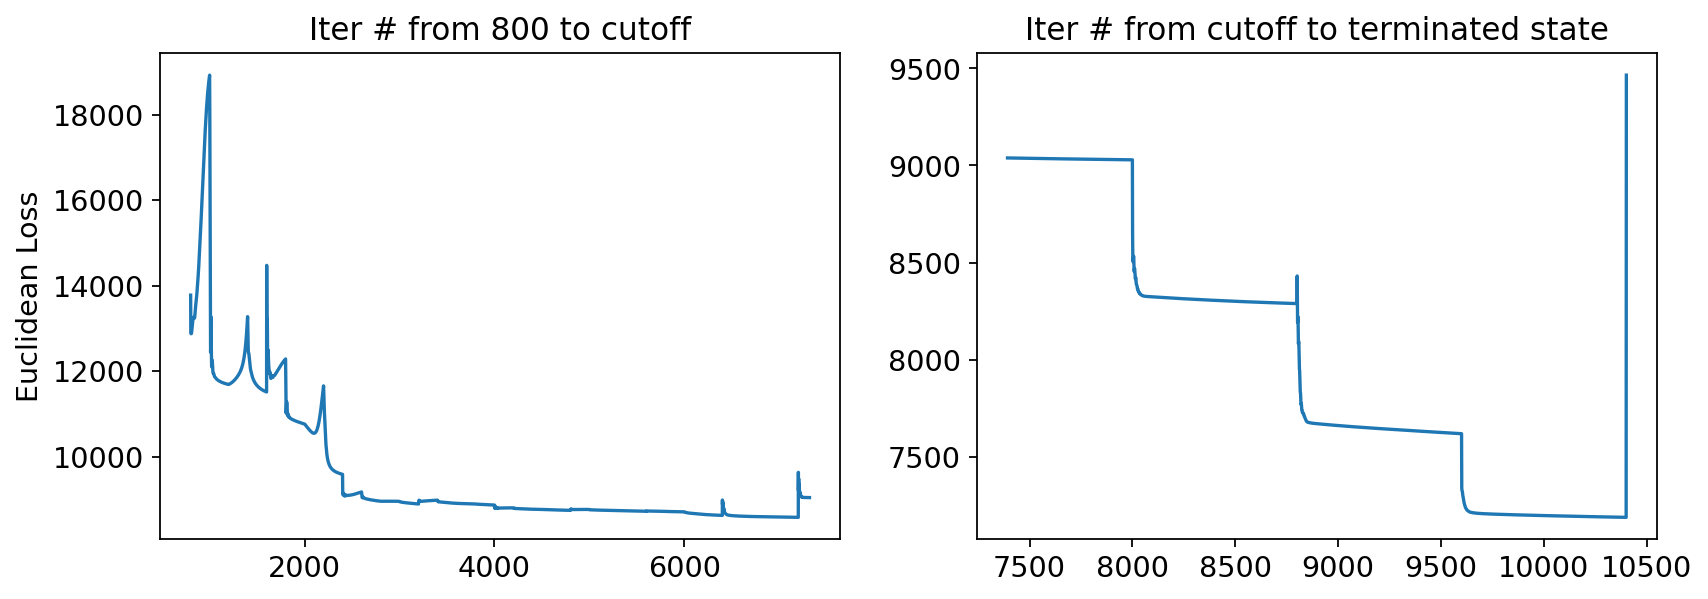

Loss (Total): 9464.788, (Spliced): 4566.018, (Unspliced): 4898.770:  87%|████████▋ | 10401/12000 [02:01<00:18, 85.31it/s]

Total loss 7188.885, vgene loss 9464.788


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/67 [00:00<?, ?it/s]

Detected 30 velocity genes.
Estimating the variance...


  0%|          | 0/67 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/67 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.55, 0.7078385011692667), (0.45, 0.10260523789858544)
KS-test result: [1. 1. 0.]
Initial induction: 53, repression: 14/67
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 889.       *********
*********                      Stage  2                       *********
*********             Velocity Refine

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 895.    *********
Change in noise variance: 0.5448
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 901.    *********
Change in noise variance: 0.0453
Change in x0: 0.6181
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 906.    *********
Change in noise variance: 0.0795
Change in x0: 0.3755
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 911.    *********
Change in noise variance: 0.0076
Change in x0: 0.2793
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 917.    *********
Change in noise variance: 0.0224
Change in x0: 0.2349
*********             Velocity Refinement Round 6    

  0%|          | 0/67 [00:00<?, ?it/s]

Detected 29 velocity genes.
Estimating the variance...


  0%|          | 0/67 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/67 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 2.]
Initial induction: 43, repression: 24/67
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.023
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.6489
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1232.    *********
Change in noise variance: 0.1427
Change in x0: 0.8436
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1310.    *********
Change in noise variance: 0.0071
Change in x0: 0.2789
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1377.    *********
Change in noise variance: 0.0041
Change in x0: 0.2193
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1409.    *********
Change in noise variance: 0.0039
Change in x0: 0.2150
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.6766816292790884, 0.5907959680112804, 0.5761385165995667, 0.4984875248788125, 0.5658825859077891]
[0.7254623349787445, 0.7261718931692419, 0.73932937804233, 0.7915340964082439, 0.7840189143597657]
Done dataset_sim38.h5ad!
num regulators: 136
num targets: 136


  0%|          | 0/136 [00:00<?, ?gene/s]

  0%|          | 0/1000 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:38<00:00, 13.45it/s, loss=-582, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:38<00:00, 12.89it/s, loss=-582, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 457/1500:  30%|███       | 456/1500 [02:32<06:11,  2.81it/s, loss=-182, v_num=1]  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1322/1500:  88%|████████▊ | 1322/1500 [07:31<01:00,  2.93it/s, loss=-363, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -499.261. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 136 highly variable genes.
Computing moments for 136 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 60 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 60 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 60 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 185650.333, (Spliced): 98002.042, (Unspliced): 87648.292: 100%|█████████▉| 11995/12000 [03:31<00:00, 46.48it/s]  

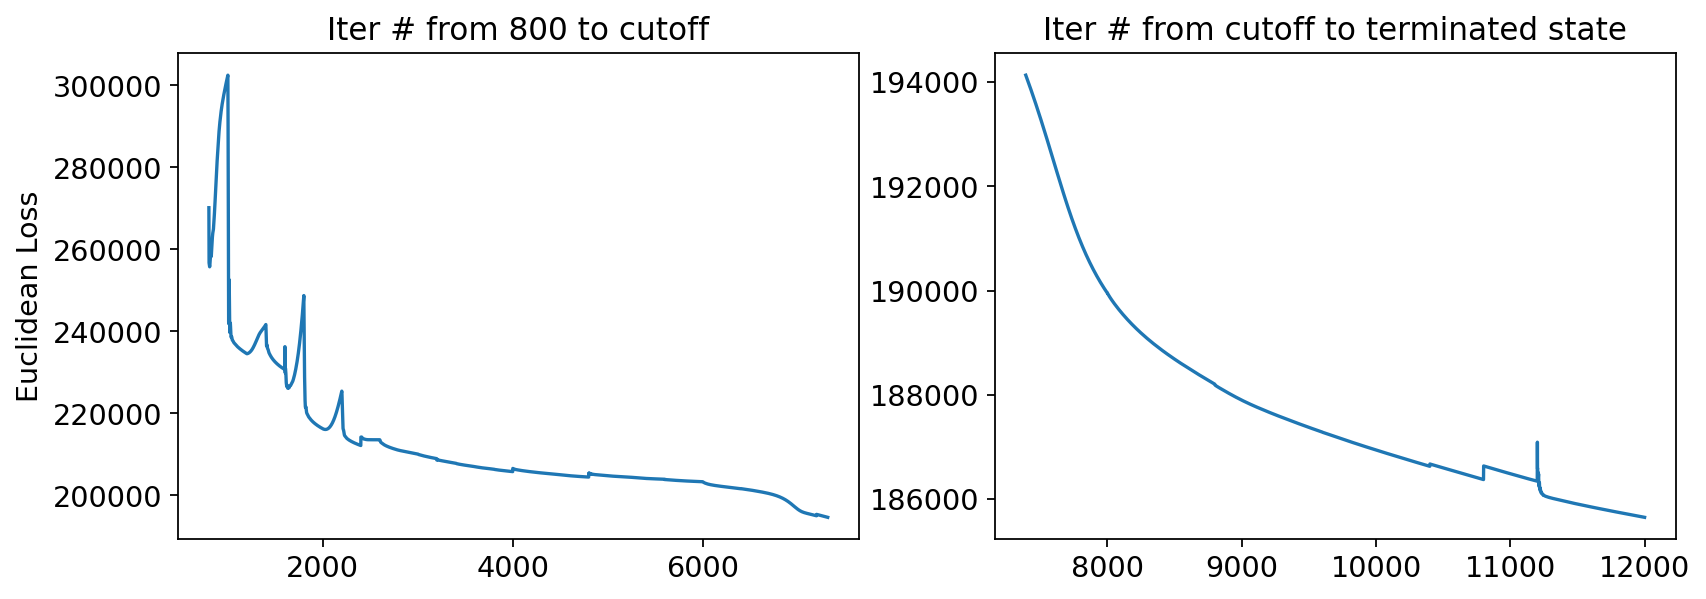

Loss (Total): 185650.333, (Spliced): 98002.042, (Unspliced): 87648.292: 100%|█████████▉| 11999/12000 [03:32<00:00, 56.34it/s]

Total loss 185650.333, vgene loss 185650.333


  0%|          | 0/1000 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/136 [00:00<?, ?it/s]

Detected 65 velocity genes.
Estimating the variance...


  0%|          | 0/136 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/136 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.55, 0.8072105734854441), (0.45, 0.30657786706184786)
KS-test result: [1. 1. 0.]
Initial induction: 104, repression: 32/136
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 6, test iteration: 10
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.028
Average Set Size: 20
*********     Round 1: Early Stop Triggered at epoch 1009.    *********
Change in noise variance: 0.4409
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1018.    *********
Change in noise variance: 0.0089
Change in x0: 0.4946
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1025.    *********
Change in noise variance: 0.0019
Change in x0: 0.3971
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1032.    *********
Change in noise variance: 0.0042
Change in x0: 0.3305
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1039.    *********
Change in noise variance: 0.0029
Change in x0: 0.3252
*********             Velocity Refinement Round 

  0%|          | 0/136 [00:00<?, ?it/s]

Detected 65 velocity genes.
Estimating the variance...


  0%|          | 0/136 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/136 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.55, 0.8180649309684621), (0.45, 0.35396602968973145)
KS-test result: [1. 1. 0.]
Initial induction: 104, repression: 32/136
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 6, test iteration: 10
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.033
Average Set Size: 20
*********     Round 1: Early Stop Triggered at epoch 1009.    *********
Change in noise variance: 0.4505
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1048.    *********
Change in noise variance: 0.0455
Change in x0: 0.4960
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1089.    *********
Change in noise variance: 0.0065
Change in x0: 0.3666
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1096.    *********
Change in noise variance: 0.0156
Change in x0: 0.3315
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1103.    *********
Change in noise variance: 0.0072
Change in x0: 0.3136
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.852664988752327, 0.7057419649735602, 0.5528213881550476, 0.43406737054480454, 0.5455194977715518]
[0.7691812881373027, 0.7673612500443402, 0.7112015699037252, 0.6506722338476355, 0.6746020846882704]
Done dataset_sim2_new.h5ad!
num regulators: 64
num targets: 64


  0%|          | 0/64 [00:00<?, ?gene/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 20.29it/s, loss=-204, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 22.03it/s, loss=-204, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1127/1500:  75%|███████▌  | 1127/1500 [05:42<01:53,  3.29it/s, loss=-116, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -207.476. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 64 highly variable genes.
Computing moments for 64 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 24 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 24 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 24 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 400.335, (Spliced): 196.476, (Unspliced): 203.859:  27%|██▋       | 3273/12000 [00:34<01:27, 99.28it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 435.860, (Spliced): 215.930, (Unspliced): 219.930:  73%|███████▎  | 8797/12000 [01:37<00:40, 78.69it/s]

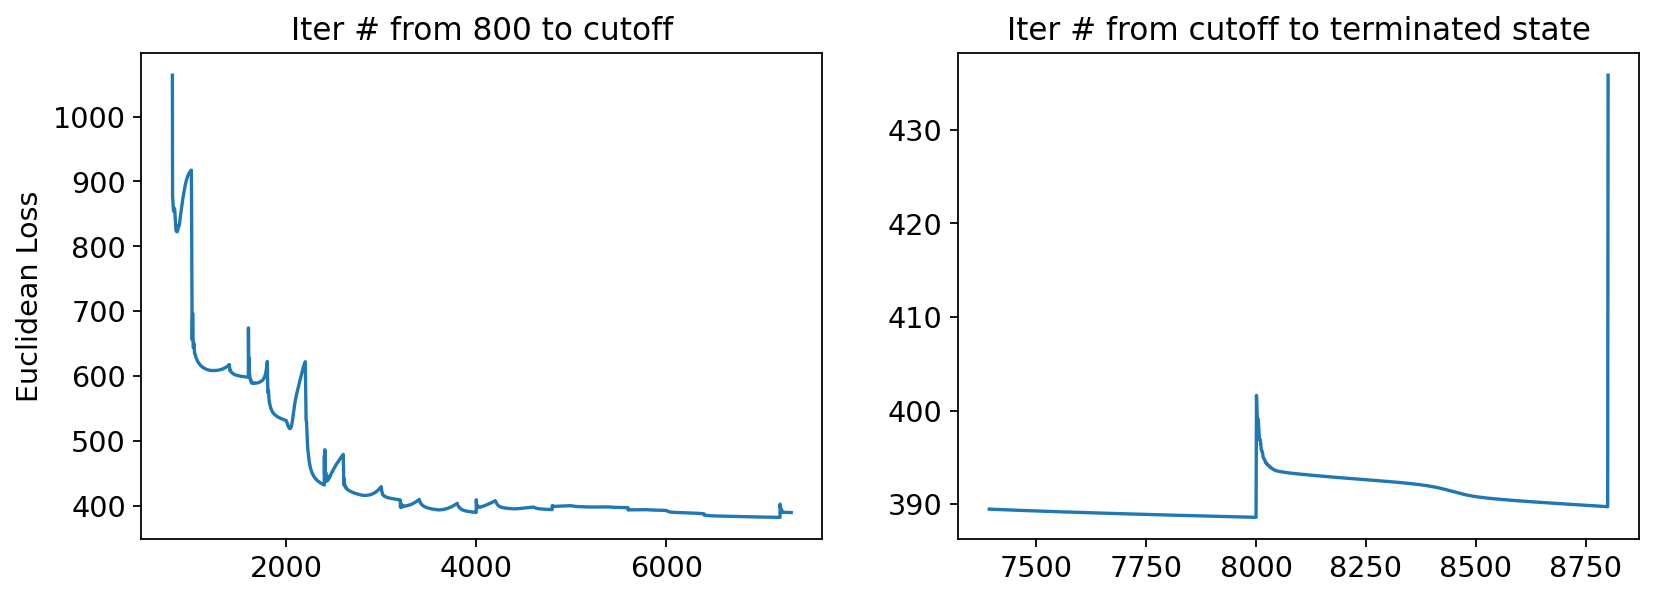

Loss (Total): 435.860, (Spliced): 215.930, (Unspliced): 219.930:  73%|███████▎  | 8801/12000 [01:38<00:35, 89.57it/s]

Total loss 388.579, vgene loss 435.860


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/64 [00:00<?, ?it/s]

Detected 25 velocity genes.
Estimating the variance...


  0%|          | 0/64 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/64 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 0 to repressive
Initial induction: 41, repression: 23/64
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.020
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1255.    *********
Change in noise variance: 0.4329
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1261.    *********
Change in noise variance: 0.0137
Change in x0: 0.9305
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1267.    *********
Change in noise variance: 0.0279
Change in x0: 0.6030
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1273.    *********
Change in noise variance: 0.0481
Change in x0: 0.4208
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1278.    *********
Change in noise variance: 0.0062
Change in x0: 0.3039
*********             Velocity Refinement Round 

  0%|          | 0/64 [00:00<?, ?it/s]

Detected 24 velocity genes.
Estimating the variance...


  0%|          | 0/64 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/64 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.52, 0.25788179927779276), (0.48, 0.7506578130565655)
KS-test result: [0. 1. 1.]
Initial induction: 48, repression: 16/64
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1029.    *********
Change in noise variance: 0.4204
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1077.    *********
Change in noise variance: 0.5249
Change in x0: 1.3724
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1082.    *********
Change in noise variance: 0.0097
Change in x0: 0.7104
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1087.    *********
Change in noise variance: 0.0058
Change in x0: 0.4542
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1093.    *********
Change in noise variance: 0.0040
Change in x0: 0.3088
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7843826265559064, 0.6579806180092566, 0.6681000603307229, 0.39122350767584285, 0.5591486782475565]
[0.7754932752926392, 0.730223611841508, 0.7364029900532709, 0.7062290100273997, 0.7746257665654247]
Done dataset_sim26.h5ad!
num regulators: 67
num targets: 67


  0%|          | 0/67 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 22.74it/s, loss=-259, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 22.48it/s, loss=-259, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 556/1500:  37%|███▋      | 555/1500 [02:40<04:41,  3.36it/s, loss=-78.6, v_num=1]   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1004/1500:  67%|██████▋   | 1004/1500 [05:01<02:28,  3.33it/s, loss=-130, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -226.817. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 67 highly variable genes.
Computing moments for 67 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 25 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 25 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 25 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 12243.970, (Spliced): 5955.896, (Unspliced): 6288.074:  20%|█▉        | 2368/12000 [00:26<02:02, 78.53it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 9745.287, (Spliced): 4933.524, (Unspliced): 4811.763: 100%|█████████▉| 11998/12000 [02:25<00:00, 68.38it/s]

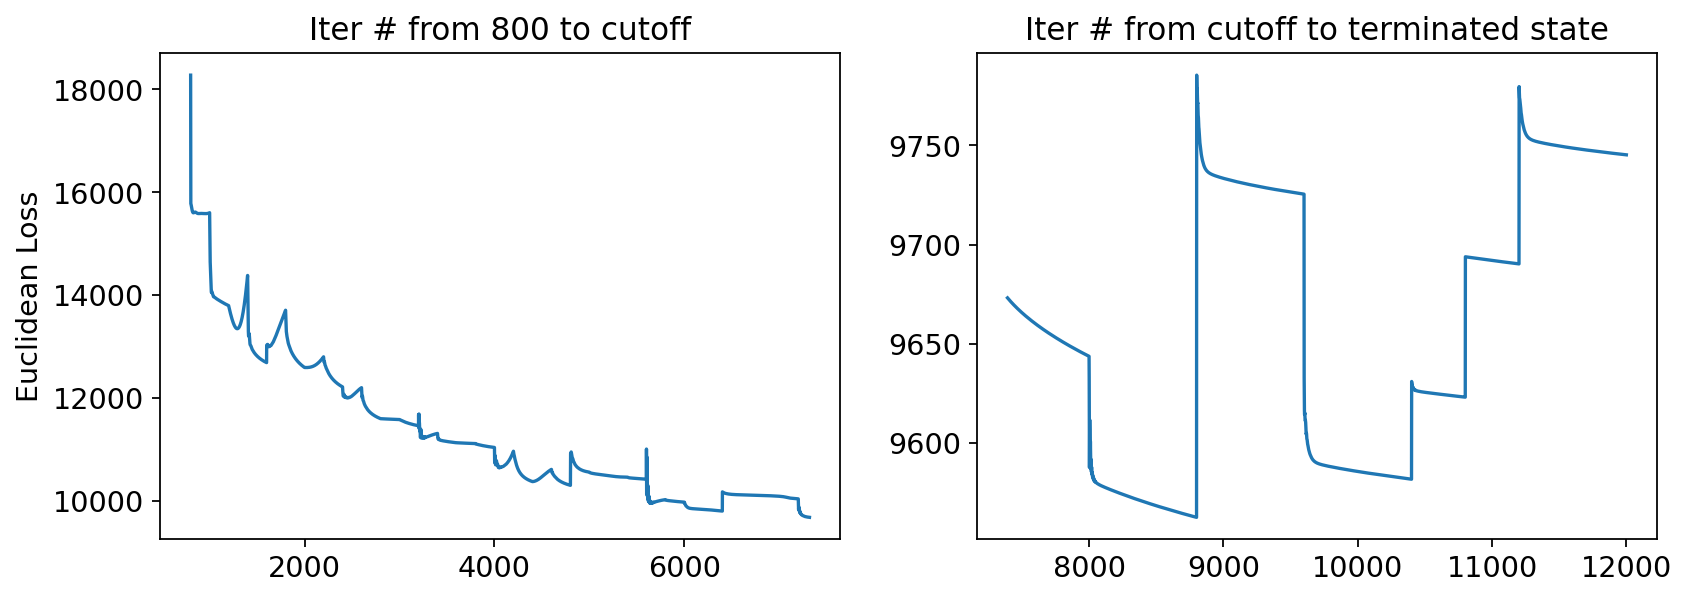

Loss (Total): 9745.287, (Spliced): 4933.524, (Unspliced): 4811.763: 100%|█████████▉| 11999/12000 [02:25<00:00, 82.22it/s]

Total loss 9562.387, vgene loss 9745.287


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/67 [00:00<?, ?it/s]

Detected 24 velocity genes.
Estimating the variance...


  0%|          | 0/67 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/67 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 1 to repressive
Initial induction: 38, repression: 29/67
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 719.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 739.    *********
Change in noise variance: 0.7196
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 807.    *********
Change in noise variance: 0.1040
Change in x0: 0.6718
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 812.    *********
Change in noise variance: 0.0035
Change in x0: 0.4355
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 817.    *********
Change in noise variance: 0.0079
Change in x0: 0.2858
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 823.    *********
Change in noise variance: 0.0040
Change in x0: 0.2365
*********             Velocity Refinement Round 6    

  0%|          | 0/67 [00:00<?, ?it/s]

Detected 24 velocity genes.
Estimating the variance...


  0%|          | 0/67 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/67 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 1 to repressive
Initial induction: 38, repression: 29/67
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 792.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.010
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 797.    *********
Change in noise variance: 0.7904
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 819.    *********
Change in noise variance: 1.0810
Change in x0: 1.1094
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 825.    *********
Change in noise variance: 0.0083
Change in x0: 0.5035
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 831.    *********
Change in noise variance: 0.0040
Change in x0: 0.3065
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 837.    *********
Change in noise variance: 0.0013
Change in x0: 0.1588
*********             Velocity Refinement Round 6    

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8229773545863932, 0.6637079985292881, 0.6281396974738017, 0.34502501667844265, 0.5041001486203698]
[0.8144209771822933, 0.714368352259101, 0.667091774478078, 0.6799388723500523, 0.7082376415272797]
Done dataset_sim29.h5ad!
num regulators: 44
num targets: 44


  0%|          | 0/44 [00:00<?, ?gene/s]

  0%|          | 0/400 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 22.96it/s, loss=-181, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 21.94it/s, loss=-181, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 564/1500:  38%|███▊      | 564/1500 [02:43<04:39,  3.35it/s, loss=-29.9, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 986/1500:  66%|██████▌   | 986/1500 [05:00<02:36,  3.28it/s, loss=-63.9, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -140.470. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 44 highly variable genes.
Computing moments for 44 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 19 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 18 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 18 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 3879882524.444, (Spliced): 2013966336.000, (Unspliced): 1865916188.444:  67%|██████▋   | 7990/12000 [01:27<00:49, 80.88it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1500/1500: 100%|██████████| 1500/1500 [07:51<00:00,  2.92it/s, loss=-175, v_num=1]

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1500/1500: 100%|██████████| 1500/1500 [07:51<00:00,  3.18it/s, loss=-175, v_num=1]
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 69 highly variable genes.
Computing moments for 69 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 28 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 28 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 28 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 134555.379, (Spliced): 66292.004, (Unspliced): 68263.375:  17%|█▋        | 2074/12000 [00:21<01:32, 107.60it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 76354.442, (Spliced): 38054.031, (Unspliced): 38300.411:  87%|████████▋ | 10398/12000 [02:02<00:21, 75.98it/s]

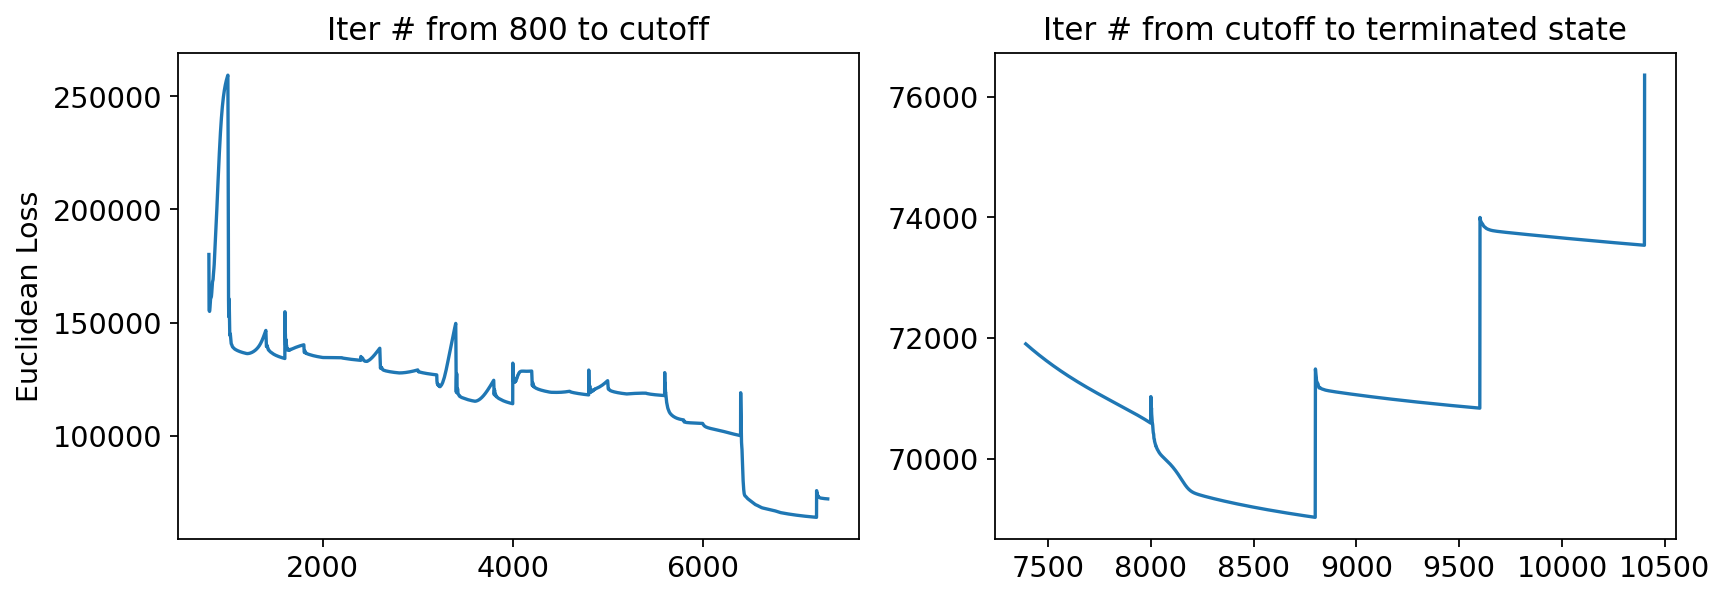

Loss (Total): 76354.442, (Spliced): 38054.031, (Unspliced): 38300.411:  87%|████████▋ | 10401/12000 [02:02<00:18, 84.76it/s]

Total loss 69034.629, vgene loss 76354.442


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/69 [00:00<?, ?it/s]

Detected 27 velocity genes.
Estimating the variance...


  0%|          | 0/69 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/69 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.59, 0.11157731157629086), (0.41, 0.8949796063574489)
KS-test result: [1. 1. 0.]
Initial induction: 51, repression: 18/69
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.050
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1253.    *********
Change in noise variance: 0.3366
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1259.    *********
Change in noise variance: 0.0284
Change in x0: 0.8489
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1328.    *********
Change in noise variance: 0.0140
Change in x0: 0.2868
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1376.    *********
Change in noise variance: 0.0110
Change in x0: 0.2054
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1449.    *********
Change in noise variance: 0.0079
Change in x0: 0.2011
*********             Velocity Refinement Round 

  0%|          | 0/69 [00:00<?, ?it/s]

Detected 27 velocity genes.
Estimating the variance...


  0%|          | 0/69 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/69 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.70, 0.8713341513879275), (0.30, 0.12864826440684649)
(0.59, 0.12779720279594528), (0.41, 0.9053270904813352)
KS-test result: [0. 1. 0.]
Initial induction: 47, repression: 22/69
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 998.       *********
*********                      Stage  2              

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.033
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1004.    *********
Change in noise variance: 0.2606
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1009.    *********
Change in noise variance: 0.0174
Change in x0: 0.9550
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1209.    *********
Change in noise variance: 0.0074
Change in x0: 0.5385
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1214.    *********
Change in noise variance: 0.0098
Change in x0: 0.4000
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1219.    *********
Change in noise variance: 0.0023
Change in x0: 0.3066
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7388882048317826, 0.5991700079593282, 0.47128371265610025, 0.4175311195287794, 0.5113201729729389]
[0.7244925524153103, 0.6589867115965485, 0.6163566980603027, 0.732879195585149, 0.7494368041948419]
Done dataset_sim33.h5ad!
num regulators: 63
num targets: 63


  0%|          | 0/63 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 497/500:  99%|█████████▉| 497/500 [00:24<00:00, 20.18it/s, loss=-261, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -233.097. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 535/1500:  36%|███▌      | 534/1500 [02:33<05:30,  2.93it/s, loss=-57.7, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1326/1500:  88%|████████▊ | 1326/1500 [06:52<00:54,  3.21it/s, loss=-136, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -232.418. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 63 highly variable genes.
Computing moments for 63 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 12 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 12 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 12 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 2917910442.667, (Spliced): 1406836992.000, (Unspliced): 1511073450.667:  17%|█▋        | 2036/12000 [00:22<01:54, 87.26it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 2060553557.333, (Spliced): 1007130368.000, (Unspliced): 1053423189.333:  93%|█████████▎| 11197/12000 [02:15<00:11, 67.74it/s]

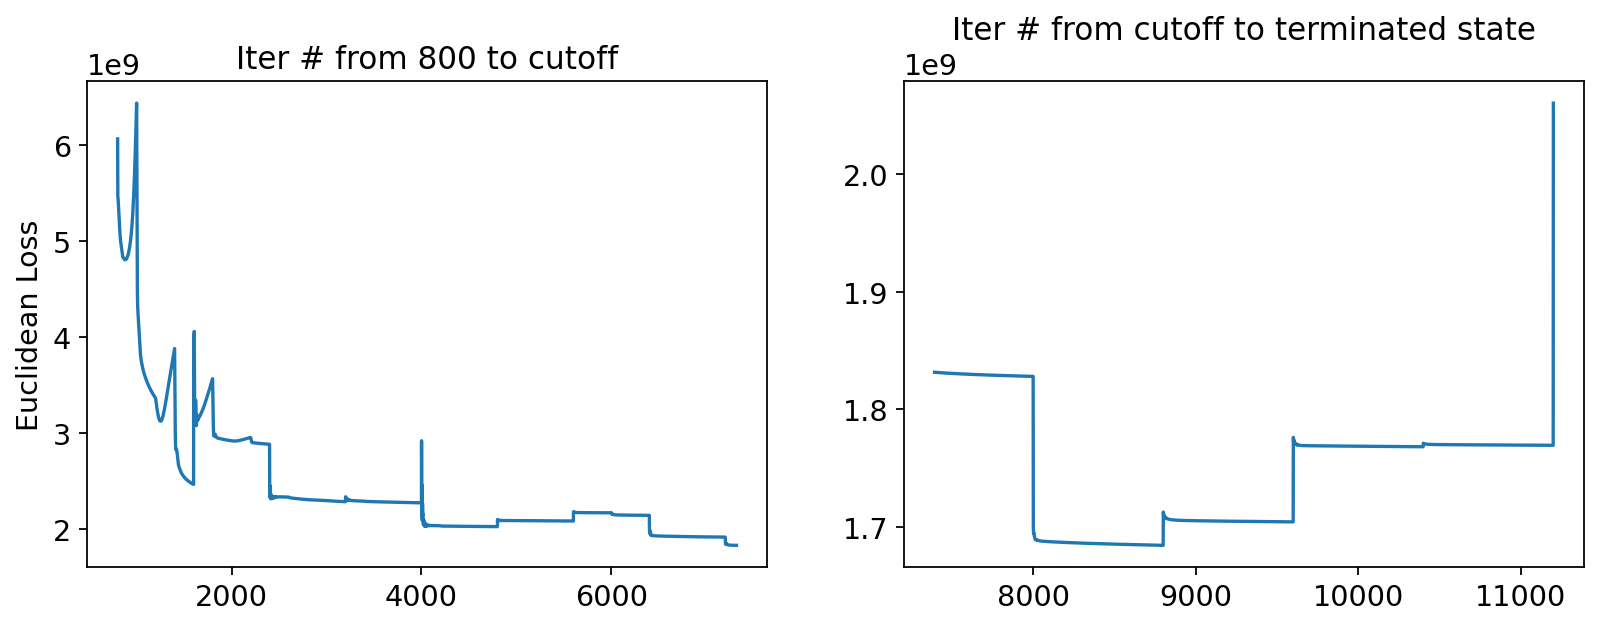

Loss (Total): 2060553557.333, (Spliced): 1007130368.000, (Unspliced): 1053423189.333:  93%|█████████▎| 11201/12000 [02:16<00:09, 82.31it/s]

Total loss 1684323925.333, vgene loss 2060553557.333


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/63 [00:00<?, ?it/s]

Detected 13 velocity genes.
Estimating the variance...


  0%|          | 0/63 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/63 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 2. 1.]
Initial induction: 37, repression: 26/63
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 526.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.057
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 916.    *********
Change in noise variance: 0.0477
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 921.    *********
Change in noise variance: 0.0007
Change in x0: 0.5085
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1222.    *********
Change in noise variance: 0.0000
Change in x0: 0.5528
*********             Velocity Refinement Round 4             *********
Stage 2: Early Stop Triggered at round 3.
*********              Finished. Total Time =   0 h :  0 m : 42 s             *********
Final: Train ELBO = -1725.907,	Test ELBO = -1796.381
Estimating ODE parameters...


  0%|          | 0/63 [00:00<?, ?it/s]

Detected 14 velocity genes.
Estimating the variance...


  0%|          | 0/63 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/63 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [2. 2. 1.]
Initial induction: 17, repression: 46/63
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.053
Average Set Size: 16
Change in noise variance: 0.0499
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1505.    *********
Change in noise variance: 0.0008
Change in x0: 0.3657
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1701.    *********
Change in noise variance: 0.0000
Change in x0: 0.4317
*********             Velocity Refinement Round 4             *********
Stage 2: Early Stop Triggered at round 3.
*********              Finished. Total Time =   0 h :  1 m : 13 s             *********
Final: Train ELBO = -1367.441,	Test ELBO = -1510.708


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.83834856326423, 0.7390931699339067, 0.6752493960947429, 0.46043385229401773, 0.5476196356475985]
[0.8128404070351776, 0.7650131800322656, 0.7322746741889843, 0.7349873701609915, 0.7459783571766114]
Done dataset_sim42.h5ad!
num regulators: 78
num targets: 78


  0%|          | 0/78 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 22.21it/s, loss=-258, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.74it/s, loss=-258, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 532/1500:  35%|███▌      | 532/1500 [02:29<05:30,  2.92it/s, loss=-101, v_num=1]  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 94232.078, (Spliced): 47487.009, (Unspliced): 46745.069:  93%|█████████▎| 11212/12000 [02:15<00:14, 55.99it/s] 

C6_TF1


Loss (Total): 93104.647, (Spliced): 46822.616, (Unspliced): 46282.030: 100%|█████████▉| 11995/12000 [02:28<00:00, 65.06it/s]

C6_TF1


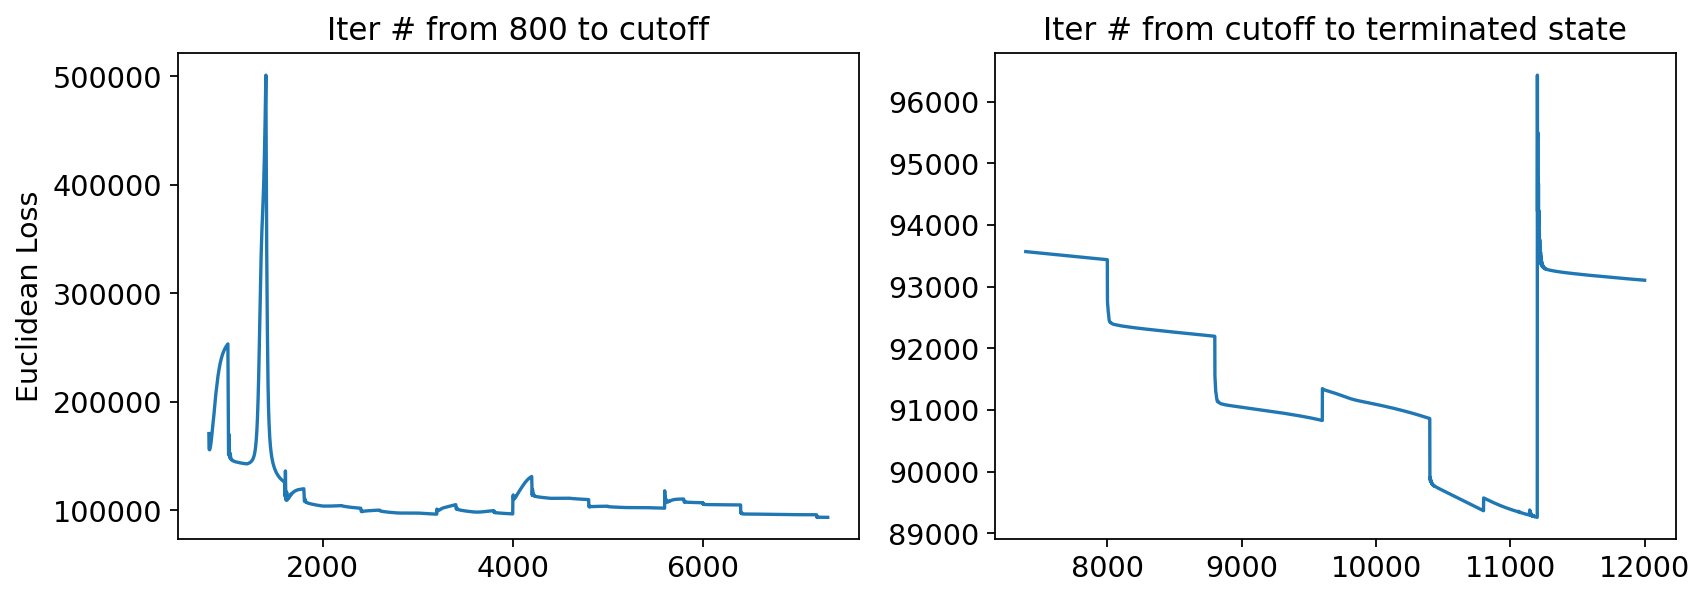

Loss (Total): 93104.647, (Spliced): 46822.616, (Unspliced): 46282.030: 100%|█████████▉| 11999/12000 [02:29<00:00, 80.43it/s]

Total loss 89259.634, vgene loss 93104.647


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/78 [00:00<?, ?it/s]

Detected 30 velocity genes.
Estimating the variance...


  0%|          | 0/78 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/78 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.57, 0.9307416235689965), (0.43, 0.2564389858374599)
KS-test result: [1. 0. 1.]
Initial induction: 62, repression: 16/78
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.003
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.2602
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1030.    *********
Change in noise variance: 0.0181
Change in x0: 1.0170
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1036.    *********
Change in noise variance: 0.0034
Change in x0: 0.5839
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1052.    *********
Change in noise variance: 0.0050
Change in x0: 0.3856
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1060.    *********
Change in noise variance: 0.0021
Change in x0: 0.2545
*********             Velocity Refinement Round 

  0%|          | 0/78 [00:00<?, ?it/s]

Detected 31 velocity genes.
Estimating the variance...


  0%|          | 0/78 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/78 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.57, 0.9177793523038145), (0.43, 0.28208004939744874)
KS-test result: [1. 0. 1.]
Initial induction: 62, repression: 16/78
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.033
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1013.    *********
Change in noise variance: 0.2247
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1106.    *********
Change in noise variance: 0.0178
Change in x0: 0.5132
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1207.    *********
Change in noise variance: 0.0004
Change in x0: 0.3712
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1215.    *********
Change in noise variance: 0.0000
Change in x0: 0.3127
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1332.    *********
Change in noise variance: 0.0000
Change in x0: 0.2688
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.72445667526129, 0.5896569149402726, 0.5486918135609996, 0.45560869410445953, 0.5584336981821543]
[0.7611993705900388, 0.7383705521472231, 0.7517945098102442, 0.7926185034382152, 0.8020202867159036]
Done dataset_sim7.h5ad!
num regulators: 153
num targets: 153


  0%|          | 0/153 [00:00<?, ?gene/s]

  0%|          | 0/1000 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 201/500:  40%|████      | 201/500 [00:15<00:23, 12.90it/s, loss=-468, v_num=1]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 934/1500:  62%|██████▏   | 934/1500 [05:45<03:29,  2.70it/s, loss=-303, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -444.900. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 153 highly variable genes.
Computing moments for 153 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 101 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 101 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 101 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 818.568, (Spliced): 405.438, (Unspliced): 413.131:  37%|███▋      | 4451/12000 [01:14<01:49, 68.67it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.022
Average Set Size: 20
*********     Round 2: Early Stop Triggered at epoch 1206.    *********
Change in noise variance: 0.0047
Change in x0: 0.2765
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1278.    *********
Change in noise variance: 0.0026
Change in x0: 0.2587
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1325.    *********
Change in noise variance: 0.0027
Change in x0: 0.2369
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1397.    *********
Change in noise variance: 0.0013
Change in x0: 0.1951
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at epoch 1429.    *********
Change in noise variance: 0.0011
Change in x0: 0.1708
*********             Veloc

  0%|          | 0/153 [00:00<?, ?it/s]

Detected 106 velocity genes.
Estimating the variance...


  0%|          | 0/153 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/153 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.58, 0.7688132970693764), (0.42, 0.24463153856516565)
KS-test result: [1. 0. 1.]
Initial induction: 117, repression: 36/153
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 6, test iteration: 10
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.025
Average Set Size: 20
*********     Round 1: Early Stop Triggered at epoch 1366.    *********
Change in noise variance: 0.1673
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1410.    *********
Change in noise variance: 0.0285
Change in x0: 0.4527
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1456.    *********
Change in noise variance: 0.0051
Change in x0: 0.3994
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1578.    *********
Change in noise variance: 0.0034
Change in x0: 0.3676
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1585.    *********
Change in noise variance: 0.0021
Change in x0: 0.3483
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.75395015959947, 0.6469338723231935, 0.5884062849618539, 0.4751339592381812, 0.6032996756501816]
[0.6207486369373232, 0.5852093389671693, 0.6179523395764623, 0.6327365244949906, 0.7336953788505488]
Done dataset_sim6_new.h5ad!
num regulators: 114
num targets: 114


  0%|          | 0/114 [00:00<?, ?gene/s]

  0%|          | 0/1000 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:42<00:00, 13.20it/s, loss=-395, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:42<00:00, 11.84it/s, loss=-395, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1085/1500:  72%|███████▏  | 1085/1500 [06:24<02:27,  2.82it/s, loss=-225, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -333.236. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 112 highly variable genes.
Computing moments for 112 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 75 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 75 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 75 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 696.188, (Spliced): 356.798, (Unspliced): 339.390:  83%|████████▎ | 9966/12000 [02:56<00:40, 50.20it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



*********     Round 1: Early Stop Triggered at epoch 1258.    *********
Change in noise variance: 0.1942
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1317.    *********
Change in noise variance: 0.0147
Change in x0: 0.3020
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1344.    *********
Change in noise variance: 0.0018
Change in x0: 0.2464
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1366.    *********
Change in noise variance: 0.0021
Change in x0: 0.2016
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1398.    *********
Change in noise variance: 0.0007
Change in x0: 0.1865
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early St

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7789381814065208, 0.6919116580053579, 0.6117345137143831, 0.4300436264289946, 0.6044416233731277]
[0.7357818257363594, 0.7442426593229845, 0.7270893196923706, 0.7448023377502409, 0.7786654074593049]
Done dataset_sim1_new.h5ad!
num regulators: 69
num targets: 69


  0%|          | 0/69 [00:00<?, ?gene/s]

  0%|          | 0/200 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:16<00:00, 30.90it/s, loss=-193, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:16<00:00, 29.56it/s, loss=-193, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1295/1500:  86%|████████▋ | 1295/1500 [06:55<01:05,  3.12it/s, loss=-146, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -231.683. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 69 highly variable genes.
Computing moments for 69 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 27 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 27 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 27 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 492.053, (Spliced): 265.053, (Unspliced): 227.000: 100%|█████████▉| 11998/12000 [02:26<00:00, 68.23it/s] 

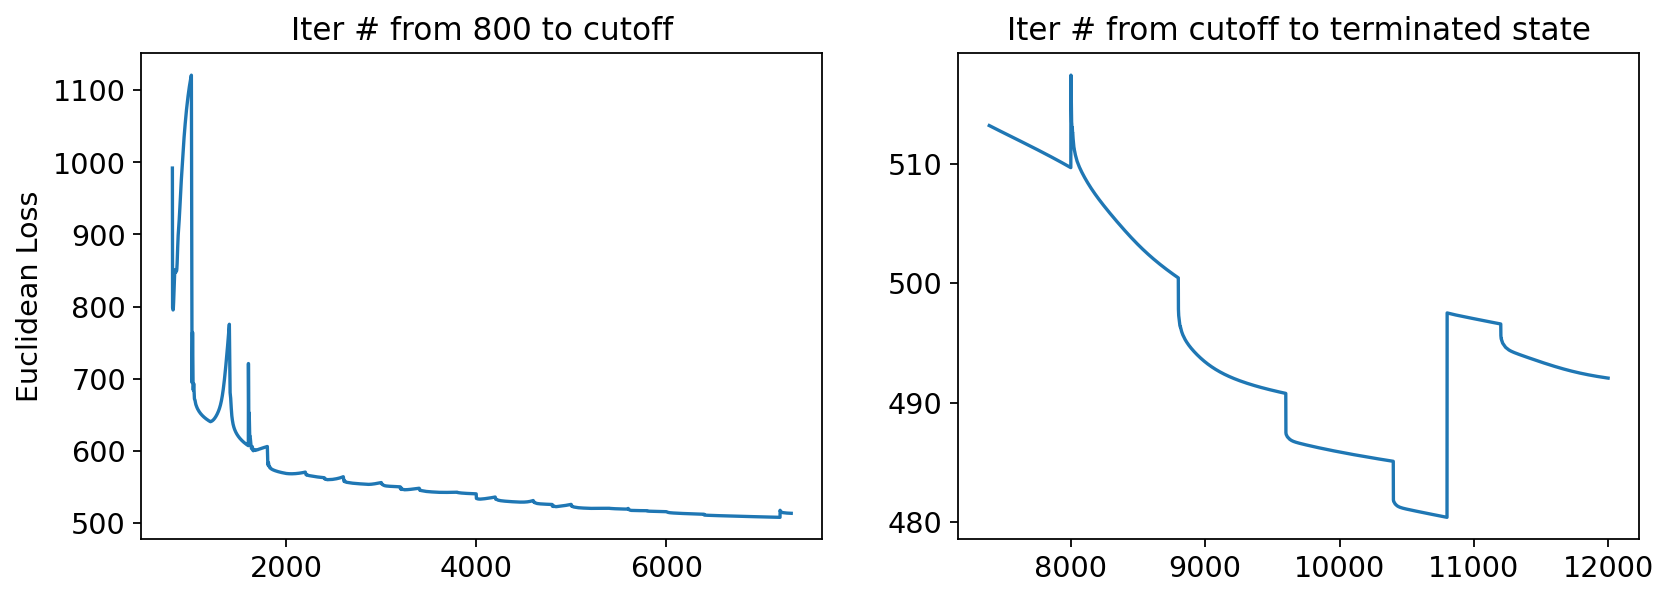

Loss (Total): 492.053, (Spliced): 265.053, (Unspliced): 227.000: 100%|█████████▉| 11999/12000 [02:27<00:00, 81.49it/s]

Total loss 480.397, vgene loss 492.053


  0%|          | 0/200 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/69 [00:00<?, ?it/s]

Detected 26 velocity genes.
Estimating the variance...


  0%|          | 0/69 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/69 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.36, 0.9223703820563003), (0.64, 0.17857350982199108)
KS-test result: [1. 0. 2.]
Initial induction: 28, repression: 41/69
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 255.       *********
*********                      Stage  2                       *********
*********             Velocity Refine

  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.075
Average Set Size: 14
Change in noise variance: 1.6686
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 847.    *********
Change in noise variance: 0.0415
Change in x0: 0.7591
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 944.    *********
Change in noise variance: 0.0104
Change in x0: 0.4511
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 974.    *********
Change in noise variance: 0.0082
Change in x0: 0.3876
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 979.    *********
Change in noise variance: 0.0053
Change in x0: 0.3077
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at epoch

  0%|          | 0/69 [00:00<?, ?it/s]

Detected 26 velocity genes.
Estimating the variance...


  0%|          | 0/69 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/69 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.36, 0.9192921244732981), (0.64, 0.22767458235982926)
KS-test result: [1. 0. 1.]
Initial induction: 45, repression: 24/69
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 350.       *********
*********                      Stage  2                       *********
*********             Velocity Refine

  0%|          | 0/200 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 11
*********     Round 1: Early Stop Triggered at epoch 591.    *********
Change in noise variance: 0.5957
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 783.    *********
Change in noise variance: 0.0242
Change in x0: 0.3625
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 788.    *********
Change in noise variance: 0.0031
Change in x0: 0.2279
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 838.    *********
Change in noise variance: 0.0018
Change in x0: 0.1802
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1166.    *********
Change in noise variance: 0.0013
Change in x0: 0.1583
*********             Velocity Refinement Round 6   

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8637402440970797, 0.7749082771682054, 0.7183307629526218, 0.3177836680629216, 0.4838229465223847]
[0.8192186723041727, 0.7651164411342617, 0.7159191885056849, 0.6922700156909454, 0.7673523150868198]
Done dataset_sim4.h5ad!
num regulators: 128
num targets: 128


  0%|          | 0/128 [00:00<?, ?gene/s]

  0%|          | 0/1000 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 441/500:  88%|████████▊ | 441/500 [00:34<00:04, 12.17it/s, loss=-576, v_num=1]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1199/1500:  80%|███████▉  | 1199/1500 [07:11<01:48,  2.78it/s, loss=-341, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -478.695. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 128 highly variable genes.
Computing moments for 128 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 61 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 61 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 61 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 49664.211, (Spliced): 24326.148, (Unspliced): 25338.064:  17%|█▋        | 2077/12000 [00:35<02:22, 69.46it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 31214.287, (Spliced): 16594.861, (Unspliced): 14619.426:  84%|████████▍ | 10105/12000 [03:03<00:38, 49.44it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[0.8471024700763444, 0.6659910493140548, 0.4332789488464666, 0.47931609455873936, 0.5820199174171402]
[0.782099272072378, 0.7356818886222496, 0.6188974098519313, 0.7407810292068571, 0.7164801743163971]
Done dataset_sim3_new.h5ad!
num regulators: 77
num targets: 77


  0%|          | 0/77 [00:00<?, ?gene/s]

  0%|          | 0/400 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.68it/s, loss=-285, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 20.89it/s, loss=-285, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1387/1500:  92%|█████████▏| 1387/1500 [07:56<00:38,  2.91it/s, loss=-169, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -265.686. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 76 highly variable genes.
Computing moments for 76 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 29 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 29 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 29 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 576.299, (Spliced): 315.161, (Unspliced): 261.138: 100%|█████████▉| 11995/12000 [02:35<00:00, 55.17it/s] 

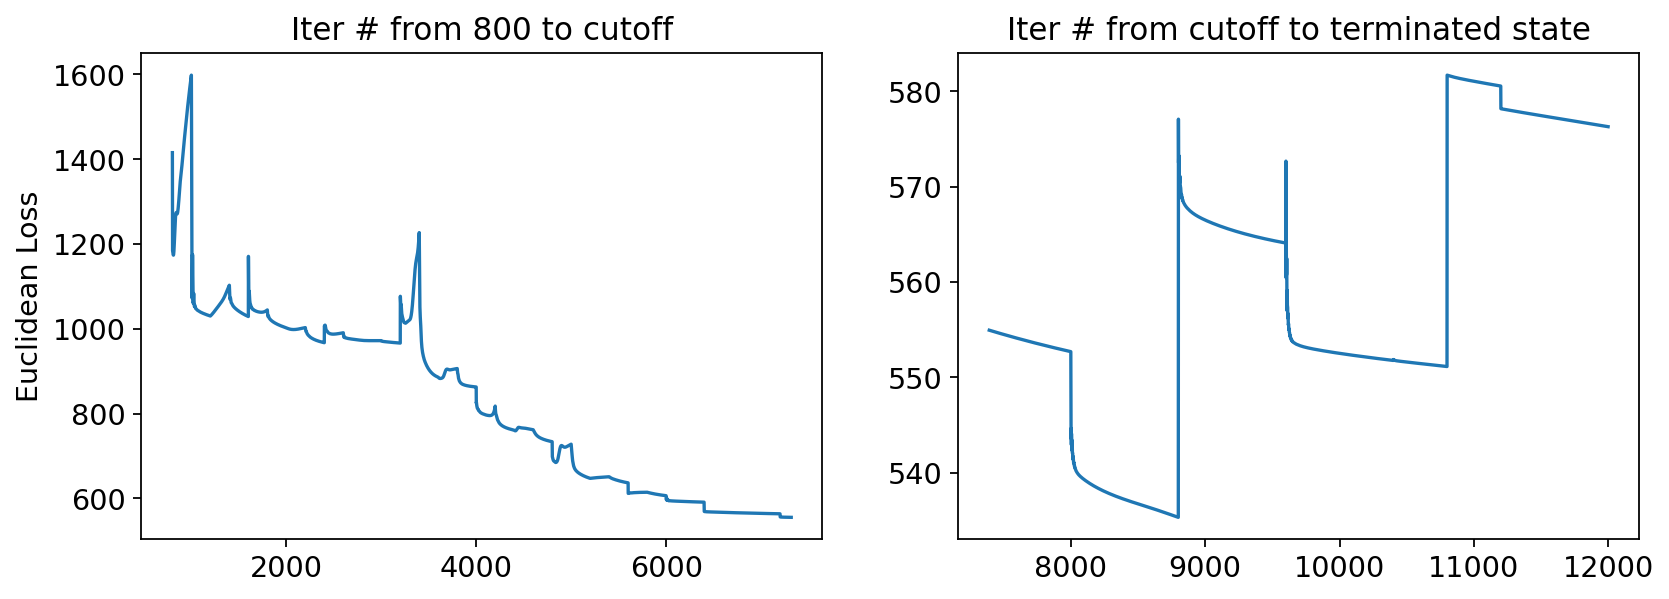

Loss (Total): 576.299, (Spliced): 315.161, (Unspliced): 261.138: 100%|█████████▉| 11999/12000 [02:36<00:00, 76.90it/s]

Total loss 535.316, vgene loss 576.299


  0%|          | 0/400 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/76 [00:00<?, ?it/s]

Detected 28 velocity genes.
Estimating the variance...


  0%|          | 0/76 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/76 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.62, 0.3238561796603096), (0.38, 0.8133978854875562)
KS-test result: [1. 2. 0.]
Initial induction: 32, repression: 44/76
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 3, test iteration: 4
*********       Stage 1: Early Stop Triggered at epoch 754.       *********
*********                      Stage  2                       *********
*********             Velocity Refinem

  0%|          | 0/400 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.028
Average Set Size: 20
*********     Round 1: Early Stop Triggered at epoch 767.    *********
Change in noise variance: 0.3752
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 774.    *********
Change in noise variance: 0.0035
Change in x0: 0.5175
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 797.    *********
Change in noise variance: 0.0022
Change in x0: 0.4149
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 814.    *********
Change in noise variance: 0.0027
Change in x0: 0.3171
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 821.    *********
Change in noise variance: 0.0020
Change in x0: 0.2492
*********             Velocity Refinement Round 6    

  0%|          | 0/76 [00:00<?, ?it/s]

Detected 28 velocity genes.
Estimating the variance...


  0%|          | 0/76 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/76 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.46, 0.2621558151329835), (0.54, 0.8696274995237102)
KS-test result: [0. 2. 2.]
Initial induction: 22, repression: 54/76
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 3, test iteration: 4
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/400 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.035
Average Set Size: 20
*********     Round 1: Early Stop Triggered at epoch 1007.    *********
Change in noise variance: 0.3618
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1014.    *********
Change in noise variance: 0.0060
Change in x0: 0.5301
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1063.    *********
Change in noise variance: 0.0088
Change in x0: 0.3907
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1069.    *********
Change in noise variance: 0.0039
Change in x0: 0.2866
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1080.    *********
Change in noise variance: 0.0010
Change in x0: 0.2331
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.757501771267453, 0.6510396372015578, 0.624941565906482, 0.3583972944558323, 0.5403658544174579]
[0.7880096140537041, 0.7633432079566114, 0.7665964024485222, 0.7488774080835705, 0.7827991637714417]
Done dataset_sim3.h5ad!
num regulators: 75
num targets: 75


  0%|          | 0/75 [00:00<?, ?gene/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 895/1500:  60%|█████▉    | 895/1500 [04:34<03:05,  3.26it/s, loss=-133, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -230.728. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 75 highly variable genes.
Computing moments for 75 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 38 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 38 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 38 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 754.144, (Spliced): 335.804, (Unspliced): 418.340:  46%|████▋     | 5561/12000 [01:02<01:24, 76.51it/s]     IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1079/1500:  72%|███████▏  | 1079/1500 [05:40<02:13,  3.16it/s, loss=-164, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -264.988. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 75 highly variable genes.
Computing moments for 75 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 25 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 25 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 25 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 97887.570, (Spliced): 47424.200, (Unspliced): 50463.370:  78%|███████▊  | 9388/12000 [01:55<00:39, 66.09it/s]   IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1050/1500:  70%|███████   | 1050/1500 [05:36<02:24,  3.12it/s, loss=-123, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -222.329. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 74 highly variable genes.
Computing moments for 74 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 33 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 33 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 33 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 390.142, (Spliced): 161.467, (Unspliced): 228.675:  21%|██▏       | 2564/12000 [00:28<01:48, 87.34it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



*********       Stage 1: Early Stop Triggered at epoch 914.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/400 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.035
Average Set Size: 19
*********     Round 1: Early Stop Triggered at epoch 921.    *********
Change in noise variance: 0.4000
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 928.    *********
Change in noise variance: 0.0433
Change in x0: 0.4640
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 973.    *********
Change in noise variance: 0.0657
Change in x0: 0.4031
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 990.    *********
Change in noise variance: 0.0054
Change in x0: 0.2830
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 997.    *********
Change in noise variance: 0.0120
Change in x0: 0.2477
*********             Velocity Refinement Round 6    

  0%|          | 0/74 [00:00<?, ?it/s]

Detected 32 velocity genes.
Estimating the variance...


  0%|          | 0/74 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/74 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.52, 0.7911475299503042), (0.48, 0.255152837124047)
KS-test result: [0. 1. 1.]
Initial induction: 58, repression: 16/74
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 3, test iteration: 4
*********       Stage 1: Early Stop Triggered at epoch 878.       *********
*********                      Stage  2                       *********
*********             Velocity Refineme

  0%|          | 0/400 [00:00<?, ?it/s]

Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7703035228456262, 0.637847786677419, 0.5377684135529223, 0.44406778797965735, 0.5629909839638758]
[0.7438351979945574, 0.6964340057876873, 0.6567975623931785, 0.7832494561454924, 0.7862471946774287]
Done dataset_sim2.h5ad!
num regulators: 70
num targets: 70


  0%|          | 0/70 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 21.71it/s, loss=-213, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:22<00:00, 21.93it/s, loss=-213, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 969/1500:  65%|██████▍   | 969/1500 [04:59<02:43,  3.24it/s, loss=-126, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -221.877. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 70 highly variable genes.
Computing moments for 70 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 33 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 33 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 33 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 2966.356, (Spliced): 1479.150, (Unspliced): 1487.206:  82%|████████▏ | 9854/12000 [01:56<00:27, 77.25it/s]  

*********       Stage 1: Early Stop Triggered at epoch 512.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 518.    *********
Change in noise variance: 0.5749
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 534.    *********
Change in noise variance: 0.1918
Change in x0: 0.8677
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 540.    *********
Change in noise variance: 0.0133
Change in x0: 0.5184
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 546.    *********
Change in noise variance: 0.0045
Change in x0: 0.3491
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 552.    *********
Change in noise variance: 0.0021
Change in x0: 0.2249
*********             Velocity Refinement Round 6    

  0%|          | 0/70 [00:00<?, ?it/s]

Detected 30 velocity genes.
Estimating the variance...


  0%|          | 0/70 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/70 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 2 to repressive
Initial induction: 40, repression: 30/70
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.037
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.4222
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0736
Change in x0: 0.6949
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1017.    *********
Change in noise variance: 0.0413
Change in x0: 0.5473
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1022.    *********
Change in noise variance: 0.0212
Change in x0: 0.3520
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1030.    *********
Change in noise variance: 0.0124
Change in x0: 0.2907
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7763726103152324, 0.6851141014802764, 0.6237898222696908, 0.4115737045270333, 0.5537056398197239]
[0.7339575250885492, 0.7104000835933821, 0.6818540562328229, 0.7077770749615427, 0.7542659210329147]
Done dataset_sim21.h5ad!
num regulators: 73
num targets: 73


  0%|          | 0/73 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.99it/s, loss=-245, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.24it/s, loss=-245, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 531/1500:  35%|███▌      | 530/1500 [02:19<05:30,  2.93it/s, loss=-81.9, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 104063.680, (Spliced): 51994.547, (Unspliced): 52069.133: 100%|█████████▉| 11994/12000 [02:36<00:00, 66.15it/s]

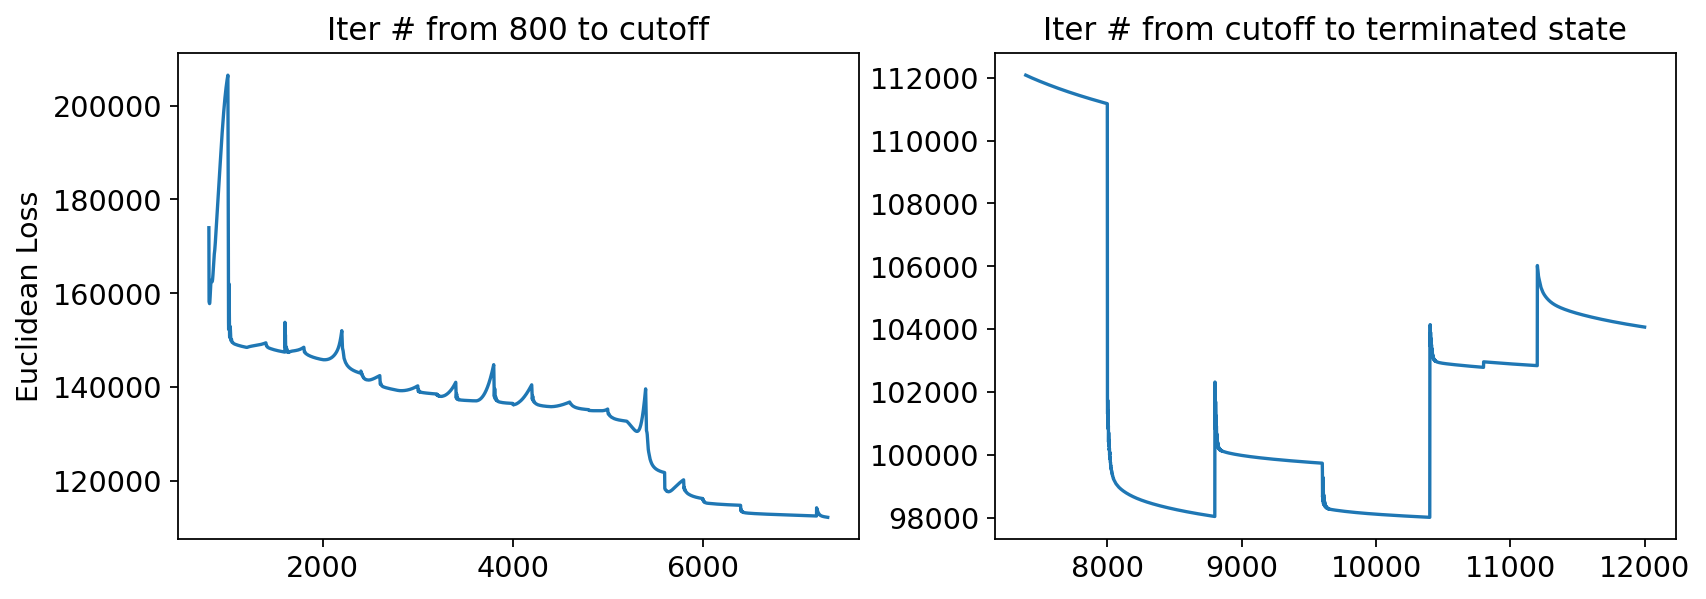

Loss (Total): 104063.680, (Spliced): 51994.547, (Unspliced): 52069.133: 100%|█████████▉| 11999/12000 [02:37<00:00, 76.19it/s]

Total loss 98007.574, vgene loss 104063.680


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/73 [00:00<?, ?it/s]

Detected 30 velocity genes.
Estimating the variance...


  0%|          | 0/73 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/73 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.45, 0.2338387720478471), (0.55, 0.8031826386531012)
(0.40, 0.9024342162012076), (0.60, 0.1929238202445446)
KS-test result: [0. 0. 1.]
Initial induction: 45, repression: 28/73
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1          

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.2571
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0139
Change in x0: 0.6227
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1017.    *********
Change in noise variance: 0.0096
Change in x0: 0.4046
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1022.    *********
Change in noise variance: 0.0018
Change in x0: 0.3049
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1028.    *********
Change in noise variance: 0.0031
Change in x0: 0.2741
*********             Velocity Refinement Round 

  0%|          | 0/73 [00:00<?, ?it/s]

Detected 30 velocity genes.
Estimating the variance...


  0%|          | 0/73 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/73 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.45, 0.2546731950304777), (0.55, 0.7814003570306362)
(0.36, 0.9230796190238042), (0.64, 0.35271435703608306)
(0.43, 0.22803030302845553), (0.57, 0.9457916954730174)
KS-test result: [0. 0. 0.]
Initial induction: 38, repression: 35/73
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
**

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.037
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.2744
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1019.    *********
Change in noise variance: 0.0262
Change in x0: 0.5668
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1046.    *********
Change in noise variance: 0.0123
Change in x0: 0.3725
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1087.    *********
Change in noise variance: 0.0010
Change in x0: 0.3147
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1108.    *********
Change in noise variance: 0.0000
Change in x0: 0.2801
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.833240313070541, 0.6862693861146063, 0.5469847540430806, 0.3659294375827398, 0.4935781618471733]
[0.7870987413663554, 0.7243798110170652, 0.6472107303042965, 0.6794440376503401, 0.761514514422448]
Done dataset_sim35.h5ad!
num regulators: 72
num targets: 72


  0%|          | 0/72 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 264/500:  53%|█████▎    | 264/500 [00:13<00:10, 22.93it/s, loss=-183, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 434.017, (Spliced): 218.582, (Unspliced): 215.435: 100%|█████████▉| 11999/12000 [02:33<00:00, 55.79it/s]

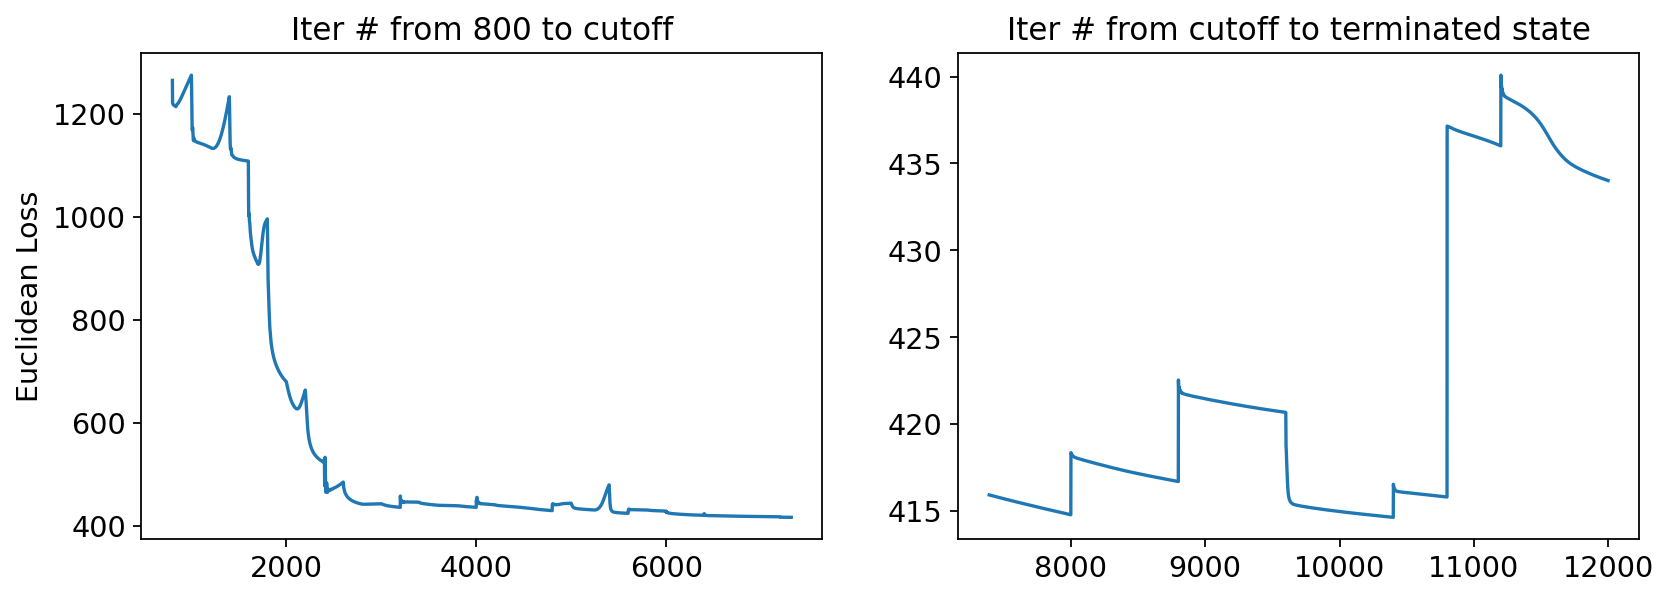

Loss (Total): 434.017, (Spliced): 218.582, (Unspliced): 215.435: 100%|█████████▉| 11999/12000 [02:33<00:00, 78.18it/s]

Total loss 414.634, vgene loss 434.017


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/72 [00:00<?, ?it/s]

Detected 34 velocity genes.
Estimating the variance...


  0%|          | 0/72 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/72 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 2. 1.]
Initial induction: 48, repression: 24/72
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.020
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1196.    *********
Change in noise variance: 0.4166
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1244.    *********
Change in noise variance: 0.0177
Change in x0: 0.9850
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1257.    *********
Change in noise variance: 0.0176
Change in x0: 0.4749
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1263.    *********
Change in noise variance: 0.0319
Change in x0: 0.2741
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1271.    *********
Change in noise variance: 0.0026
Change in x0: 0.2168
*********             Velocity Refinement Round 

  0%|          | 0/72 [00:00<?, ?it/s]

Detected 35 velocity genes.
Estimating the variance...


  0%|          | 0/72 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/72 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.58, 0.3060180598168423), (0.42, 0.8589338515678955)
KS-test result: [1. 2. 0.]
Initial induction: 36, repression: 36/72
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.020
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.3366
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0128
Change in x0: 0.5016
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1018.    *********
Change in noise variance: 0.0017
Change in x0: 0.3892
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1024.    *********
Change in noise variance: 0.0023
Change in x0: 0.2959
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1030.    *********
Change in noise variance: 0.0017
Change in x0: 0.2595
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7732725018717653, 0.65578874664772, 0.5755147538064306, 0.3913411684454413, 0.50623563549206]
[0.7694902362813208, 0.7205003702381257, 0.674140957817066, 0.6935652183807027, 0.746355663282568]
Done dataset_sim14.h5ad!
num regulators: 81
num targets: 81


  0%|          | 0/81 [00:00<?, ?gene/s]

  0%|          | 0/200 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:15<00:00, 29.49it/s, loss=-246, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:15<00:00, 31.89it/s, loss=-246, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 551/1500:  37%|███▋      | 551/1500 [02:42<05:26,  2.91it/s, loss=-104, v_num=1]  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1153/1500:  77%|███████▋  | 1153/1500 [06:06<01:50,  3.15it/s, loss=-173, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -276.214. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 81 highly variable genes.
Computing moments for 81 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 35 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 35 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 35 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 840.680, (Spliced): 415.182, (Unspliced): 425.498:  22%|██▏       | 2661/12000 [00:27<01:54, 81.31it/s]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



num regulators: 63
num targets: 63


  0%|          | 0/63 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 21.48it/s, loss=-242, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.83it/s, loss=-242, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1054/1500:  70%|███████   | 1054/1500 [05:06<02:09,  3.44it/s, loss=-111, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -212.701. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 63 highly variable genes.
Computing moments for 63 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 19 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 19 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 19 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 137276.664, (Spliced): 65070.618, (Unspliced): 72206.046:   4%|▍         | 539/12000 [00:06<01:51, 102.64it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 98654.007, (Spliced): 50890.911, (Unspliced): 47763.095:  60%|██████    | 7213/12000 [01:22<01:19, 60.01it/s]  

B2_TF1
B2_TF2


Loss (Total): 97440.053, (Spliced): 50414.868, (Unspliced): 47025.184:  67%|██████▋   | 8010/12000 [01:33<00:58, 67.81it/s]

B2_TF1
B2_TF2


Loss (Total): 97307.543, (Spliced): 50348.020, (Unspliced): 46959.523:  73%|███████▎  | 8812/12000 [01:45<00:54, 58.15it/s]

B2_TF1
B2_TF2


Loss (Total): 96836.674, (Spliced): 50206.194, (Unspliced): 46630.480:  80%|████████  | 9611/12000 [01:57<00:39, 60.48it/s]

B2_TF1
B2_TF2


Loss (Total): 96906.694, (Spliced): 50196.595, (Unspliced): 46710.099:  87%|████████▋ | 10411/12000 [02:08<00:24, 65.48it/s]

B2_TF1
B2_TF2


Loss (Total): 96985.816, (Spliced): 50325.546, (Unspliced): 46660.270:  93%|█████████▎| 11177/12000 [02:19<00:12, 65.85it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7790263088128355, 0.683798876737276, 0.5460405309967216, 0.5129266965748962, 0.5139622166490638]
[0.7823470370214716, 0.7865357677338011, 0.7616176350274347, 0.7675442423453391, 0.7801854954691482]
Done dataset_sim17.h5ad!
num regulators: 56
num targets: 56


  0%|          | 0/56 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.51it/s, loss=-237, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.81it/s, loss=-237, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1228/1500:  82%|████████▏ | 1228/1500 [06:29<01:26,  3.15it/s, loss=-84.1, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -182.873. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 56 highly variable genes.
Computing moments for 56 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 27 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 27 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 27 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 6889877655.704, (Spliced): 3421918549.333, (Unspliced): 3467959106.370:  21%|██▏       | 2566/12000 [00:26<01:28, 107.17it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 3557006753.185, (Spliced): 1813763109.926, (Unspliced): 1743243643.259:  87%|████████▋ | 10396/12000 [02:01<00:24, 66.80it/s]

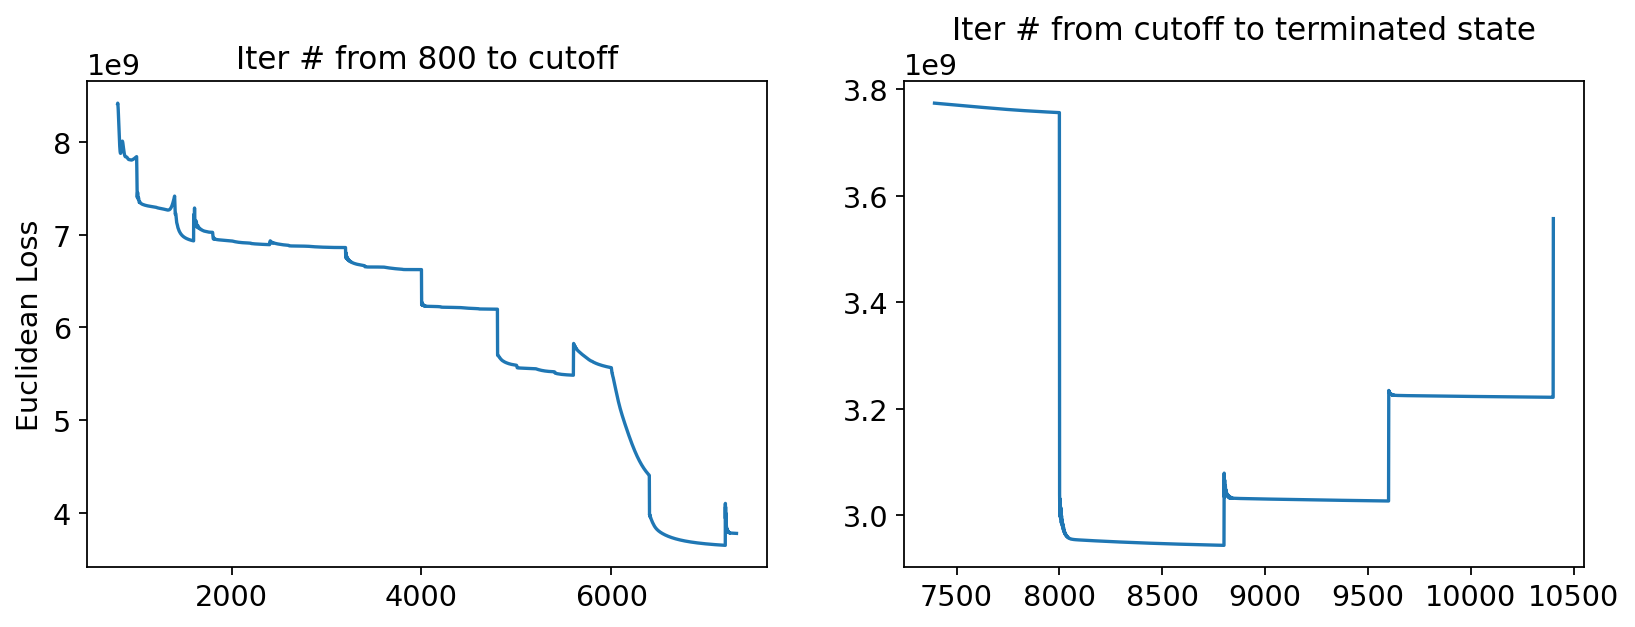

Loss (Total): 3557006753.185, (Spliced): 1813763109.926, (Unspliced): 1743243643.259:  87%|████████▋ | 10401/12000 [02:01<00:18, 85.30it/s]

Total loss 2944005006.222, vgene loss 3557006753.185


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/56 [00:00<?, ?it/s]

Detected 27 velocity genes.
Estimating the variance...


  0%|          | 0/56 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/56 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.54, 0.9217786430172092), (0.46, 0.27269177617912094)
KS-test result: [1. 0. 1.]
Initial induction: 44, repression: 12/56
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 570.       *********
*********                      Stage  2                       *********
*********             Velocity Refine

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.023
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 576.    *********
Change in noise variance: 0.0811
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 699.    *********
Change in noise variance: 0.0008
Change in x0: 0.3179
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 705.    *********
Change in noise variance: 0.0000
Change in x0: 0.2907
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 711.    *********
Change in noise variance: 0.0000
Change in x0: 0.2665
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 744.    *********
Change in noise variance: 0.0000
Change in x0: 0.2513
*********             Velocity Refinement Round 6    

  0%|          | 0/56 [00:00<?, ?it/s]

Detected 26 velocity genes.
Estimating the variance...


  0%|          | 0/56 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/56 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.46, 0.9349846329769022), (0.54, 0.3508916276109294)
KS-test result: [1. 0. 1.]
Initial induction: 39, repression: 17/56
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 563.       *********
*********                      Stage  2                       *********
*********             Velocity Refinem

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.033
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 768.    *********
Change in noise variance: 0.1010
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 774.    *********
Change in noise variance: 0.0007
Change in x0: 0.3015
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 873.    *********
Change in noise variance: 0.0000
Change in x0: 0.2532
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 882.    *********
Change in noise variance: 0.0000
Change in x0: 0.2922
*********             Velocity Refinement Round 5             *********
Stage 2: Early Stop Triggered at round 4.
*********              Finished. Total Time =   0 h :  0 m : 35 s             *********
Final: Train ELBO = -1111.235,	Test ELBO = -1207

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[nan, nan, nan, nan, nan]
[nan, nan, nan, nan, nan]
Done dataset_sim37.h5ad!
num regulators: 76
num targets: 76


  0%|          | 0/76 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 19.86it/s, loss=-257, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 19.80it/s, loss=-257, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 546/1500:  36%|███▋      | 545/1500 [02:48<05:15,  3.03it/s, loss=-86.6, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1107/1500:  74%|███████▍  | 1107/1500 [05:53<02:05,  3.13it/s, loss=-147, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -251.333. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 75 highly variable genes.
Computing moments for 75 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 28 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 28 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 28 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 1274.910, (Spliced): 555.482, (Unspliced): 719.428:  20%|██        | 2436/12000 [00:25<01:52, 85.25it/s]    IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1112.    *********
Change in noise variance: 0.3875
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1123.    *********
Change in noise variance: 0.0209
Change in x0: 0.7718
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1132.    *********
Change in noise variance: 0.0018
Change in x0: 0.5312
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1152.    *********
Change in noise variance: 0.0015
Change in x0: 0.4080
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1157.    *********
Change in noise variance: 0.0007
Change in x0: 0.3476
*********             Velocity Refinement Round 

  0%|          | 0/75 [00:00<?, ?it/s]

Detected 28 velocity genes.
Estimating the variance...


  0%|          | 0/75 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/75 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 2 to repressive
Initial induction: 44, repression: 31/75
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.007
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1005.    *********
Change in noise variance: 0.5077
*********             Velocity Refinement Round 2             *********
*********     Round 5: Early Stop Triggered at epoch 1157.    *********
Change in noise variance: 0.0000
Change in x0: 0.1668
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at epoch 1192.    *********
Change in noise variance: 0.0000
Change in x0: 0.1253
*********             Velocity Refinement Round 7             *********
*********     Round 7: Early Stop Triggered at epoch 1211.    *********
Change in noise variance: 0.0000
Change in x0: 0.0914
*********             Velocity Refinement Round 8             *********
*********     Round 8: Early Stop Triggered at epoch 1265.    *********
Change in noise variance: 0.0000
Change in x0: 0.0740
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8496280527734311, 0.693908236455604, 0.5773441622646694, 0.3904833391157745, 0.4205136627556776]
[0.7701234058253899, 0.6673334880019035, 0.600892910710465, 0.717225496838398, 0.7322069618554639]
Done dataset_sim19.h5ad!
num regulators: 72
num targets: 72


  0%|          | 0/72 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.25it/s, loss=-252, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.05it/s, loss=-252, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1157/1500:  77%|███████▋  | 1157/1500 [06:18<01:52,  3.05it/s, loss=-146, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -247.488. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 72 highly variable genes.
Computing moments for 72 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 31 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 31 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 31 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 2769.843, (Spliced): 1417.499, (Unspliced): 1352.344:  67%|██████▋   | 7994/12000 [01:30<00:51, 77.84it/s]  

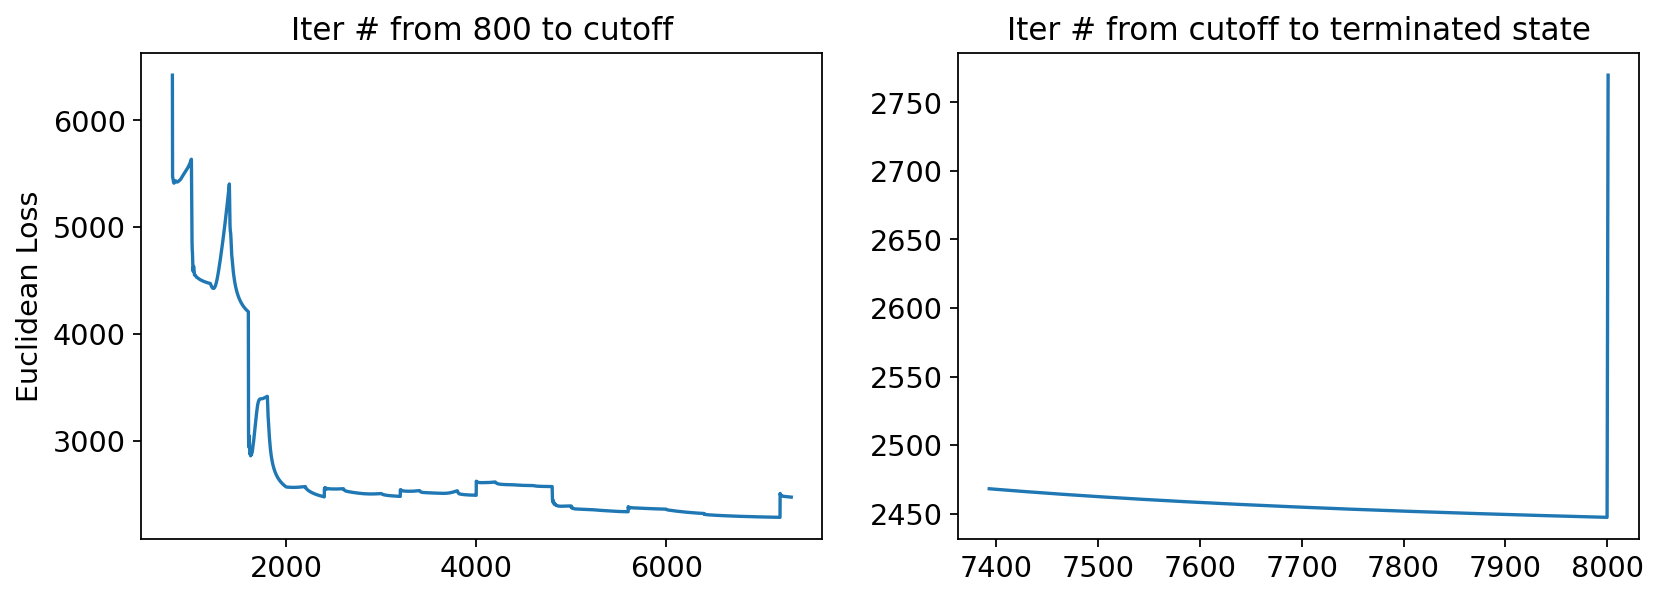

Loss (Total): 2769.843, (Spliced): 1417.499, (Unspliced): 1352.344:  67%|██████▋   | 8001/12000 [01:31<00:45, 87.54it/s]

Total loss 2447.399, vgene loss 2769.843


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/72 [00:00<?, ?it/s]

Detected 29 velocity genes.
Estimating the variance...


  0%|          | 0/72 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/72 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.68, 0.14285714285529852), (0.32, 0.9079117263370629)
(0.44, 0.13019208024746448), (0.56, 0.713352568327768)
KS-test result: [0. 0. 1.]
Initial induction: 42, repression: 30/72
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1         

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.050
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1145.    *********
Change in noise variance: 0.3593
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1296.    *********
Change in noise variance: 0.0458
Change in x0: 0.6983
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1301.    *********
Change in noise variance: 0.0308
Change in x0: 0.4472
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1306.    *********
Change in noise variance: 0.0022
Change in x0: 0.3411
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1312.    *********
Change in noise variance: 0.0094
Change in x0: 0.2930
*********             Velocity Refinement Round 

  0%|          | 0/72 [00:00<?, ?it/s]

Detected 28 velocity genes.
Estimating the variance...


  0%|          | 0/72 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/72 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.36, 0.872505510259197), (0.64, 0.17418154761691396)
(0.61, 0.2778450856930819), (0.39, 0.8300736627705013)
KS-test result: [0. 2. 0.]
Initial induction: 16, repression: 56/72
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1          

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.050
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1491.    *********
Change in noise variance: 0.4142
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1535.    *********
Change in noise variance: 0.0448
Change in x0: 0.9153
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1586.    *********
Change in noise variance: 0.0346
Change in x0: 0.4711
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1651.    *********
Change in noise variance: 0.0043
Change in x0: 0.3510
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1676.    *********
Change in noise variance: 0.0167
Change in x0: 0.3176
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8441557007990254, 0.7119148083263179, 0.5483766593592416, 0.3347442582173629, 0.4475754941192713]
[0.8243776215620102, 0.7607185369842773, 0.6372241208989107, 0.6799655979135063, 0.7266852129449436]
Done dataset_sim25.h5ad!
num regulators: 74
num targets: 74


  0%|          | 0/74 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 20.35it/s, loss=-323, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:23<00:00, 20.94it/s, loss=-323, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 531/1500:  35%|███▌      | 530/1500 [02:43<04:50,  3.34it/s, loss=-68.5, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 20212558506.667, (Spliced): 9573717333.333, (Unspliced): 10638841173.333: 100%|█████████▉| 11996/12000 [02:30<00:00, 66.30it/s] 

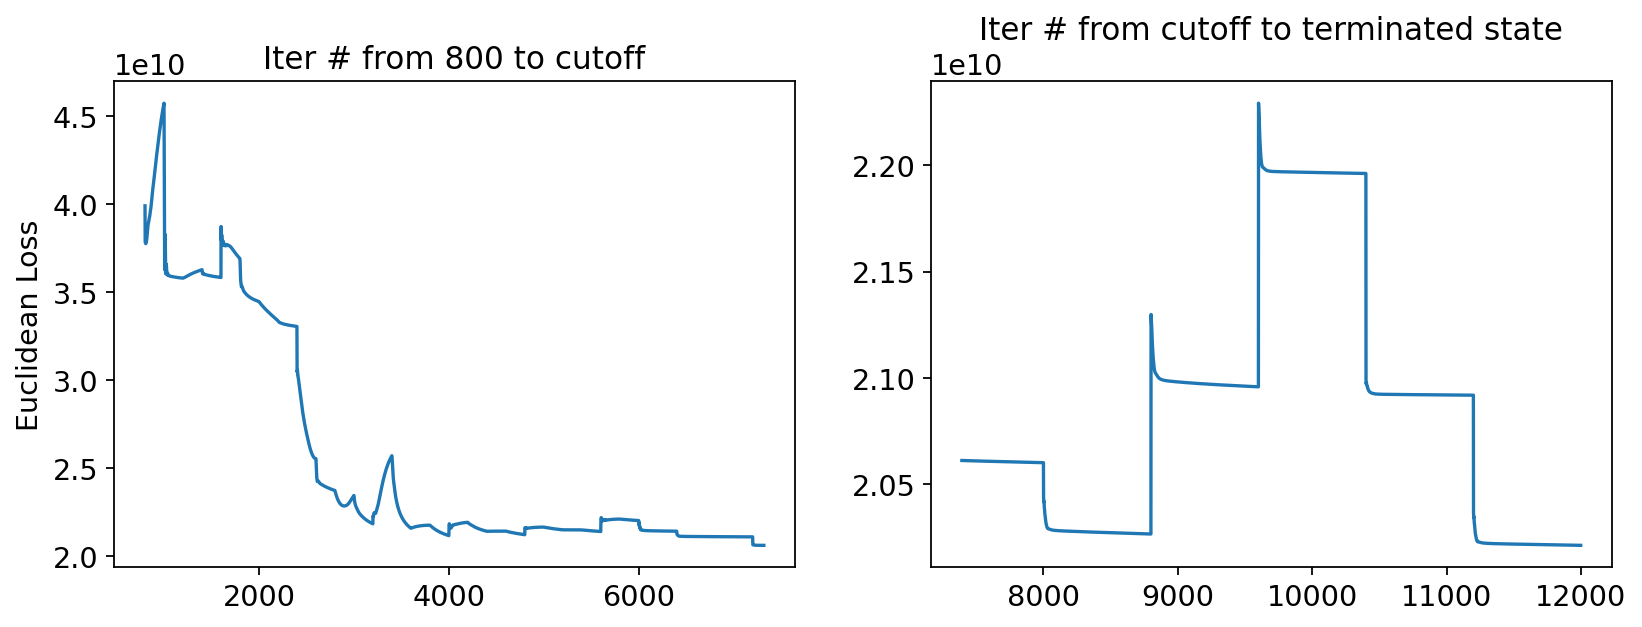

Loss (Total): 20212558506.667, (Spliced): 9573717333.333, (Unspliced): 10638841173.333: 100%|█████████▉| 11999/12000 [02:30<00:00, 79.67it/s]

Total loss 20212558506.667, vgene loss 20212558506.667


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/74 [00:00<?, ?it/s]

Detected 14 velocity genes.
Estimating the variance...


  0%|          | 0/74 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/74 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.71, 0.2405393561053325), (0.29, 0.8073118528437266)
(0.39, 0.8270762262093111), (0.61, 0.24915131543370303)
KS-test result: [0. 0. 2.]
Initial induction: 17, repression: 57/74
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1         

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.057
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.0494
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1100.    *********
Change in noise variance: 0.0006
Change in x0: 0.4034
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1132.    *********
Change in noise variance: 0.0000
Change in x0: 0.3177
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1156.    *********
Change in noise variance: 0.0000
Change in x0: 0.2605
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1164.    *********
Change in noise variance: 0.0000
Change in x0: 0.2259
*********             Velocity Refinement Round 

  0%|          | 0/74 [00:00<?, ?it/s]

Detected 14 velocity genes.
Estimating the variance...


  0%|          | 0/74 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/74 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.64, 0.12321428571231698), (0.36, 0.8486329026492392)
KS-test result: [2. 2. 0.]
Initial induction: 12, repression: 62/74
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 675.       *********
*********                      Stage  2                       *********
*********             Velocity Refine

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.047
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 681.    *********
Change in noise variance: 0.0534
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 822.    *********
Change in noise variance: 0.0009
Change in x0: 0.7403
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 853.    *********
Change in noise variance: 0.0000
Change in x0: 0.5858
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 858.    *********
Change in noise variance: 0.0000
Change in x0: 0.5056
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 872.    *********
Change in noise variance: 0.0000
Change in x0: 0.4172
*********             Velocity Refinement Round 6    

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8158976692347049, 0.7125721610039227, 0.6642467033783851, 0.3714753037309549, 0.4828838487144993]
[0.7950917610339495, 0.7588982919887471, 0.7078074109374891, 0.6802577950575085, 0.7337646394056011]
Done dataset_sim31.h5ad!
num regulators: 75
num targets: 75


  0%|          | 0/75 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 19.16it/s, loss=-295, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.06it/s, loss=-295, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 519/1500:  35%|███▍      | 519/1500 [02:40<05:37,  2.91it/s, loss=-80.1, v_num=1]  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 5799588730.435, (Spliced): 3016879237.565, (Unspliced): 2782709492.870:  87%|████████▋ | 10394/12000 [02:08<00:21, 74.80it/s]

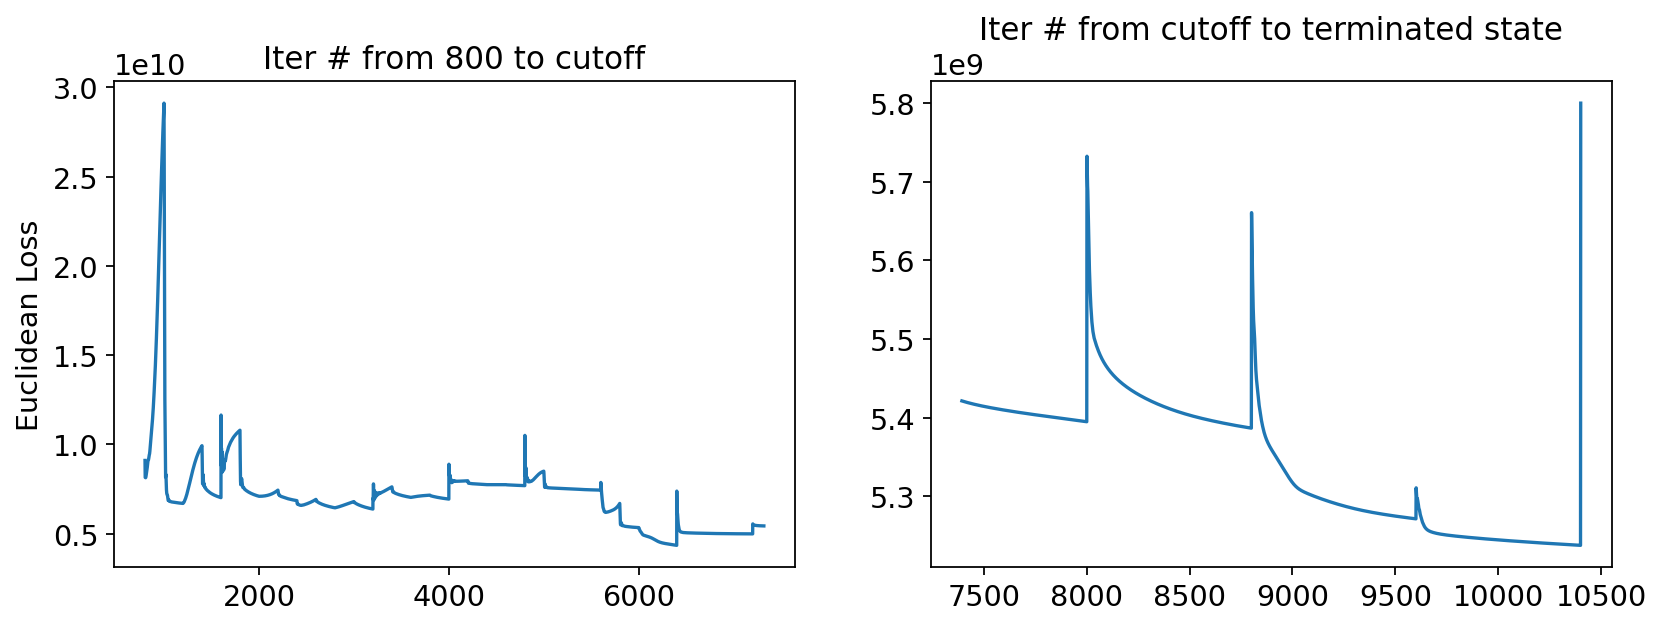

Loss (Total): 5799588730.435, (Spliced): 3016879237.565, (Unspliced): 2782709492.870:  87%|████████▋ | 10401/12000 [02:09<00:19, 80.40it/s]

Total loss 5237890537.739, vgene loss 5799588730.435


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/75 [00:00<?, ?it/s]

Detected 25 velocity genes.
Estimating the variance...


  0%|          | 0/75 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/75 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.53, 0.801817798162589), (0.47, 0.30002161126201793)
KS-test result: [0. 1. 2.]
Initial induction: 42, repression: 33/75
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.010
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.0294
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0001
Change in x0: 0.8555
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1018.    *********
Change in noise variance: 0.0000
Change in x0: 0.5988
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1024.    *********
Change in noise variance: 0.0000
Change in x0: 0.4786
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1029.    *********
Change in noise variance: 0.0000
Change in x0: 0.3317
*********             Velocity Refinement Round 

  0%|          | 0/75 [00:00<?, ?it/s]

Detected 26 velocity genes.
Estimating the variance...


  0%|          | 0/75 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/75 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.47, 0.8908982229383574), (0.53, 0.3264559541820671)
KS-test result: [0. 1. 2.]
Initial induction: 34, repression: 41/75
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.0303
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0001
Change in x0: 0.6031
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1018.    *********
Change in noise variance: 0.0000
Change in x0: 0.4606
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1024.    *********
Change in noise variance: 0.0000
Change in x0: 0.4127
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1029.    *********
Change in noise variance: 0.0000
Change in x0: 0.3095
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8213454727056893, 0.6498658149400094, 0.5475540494624209, 0.44493600446338927, 0.5411826964180689]
[0.7722660736173572, 0.6961426079956933, 0.6544398863439331, 0.6926120415850654, 0.7270735564237152]
Done dataset_sim11.h5ad!
num regulators: 77
num targets: 77


  0%|          | 0/77 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 22.04it/s, loss=-240, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 19.64it/s, loss=-240, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 518/1500:  34%|███▍      | 517/1500 [02:28<04:57,  3.30it/s, loss=-78.1, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 538.245, (Spliced): 263.279, (Unspliced): 274.966:  90%|█████████ | 10800/12000 [02:12<00:19, 62.99it/s]

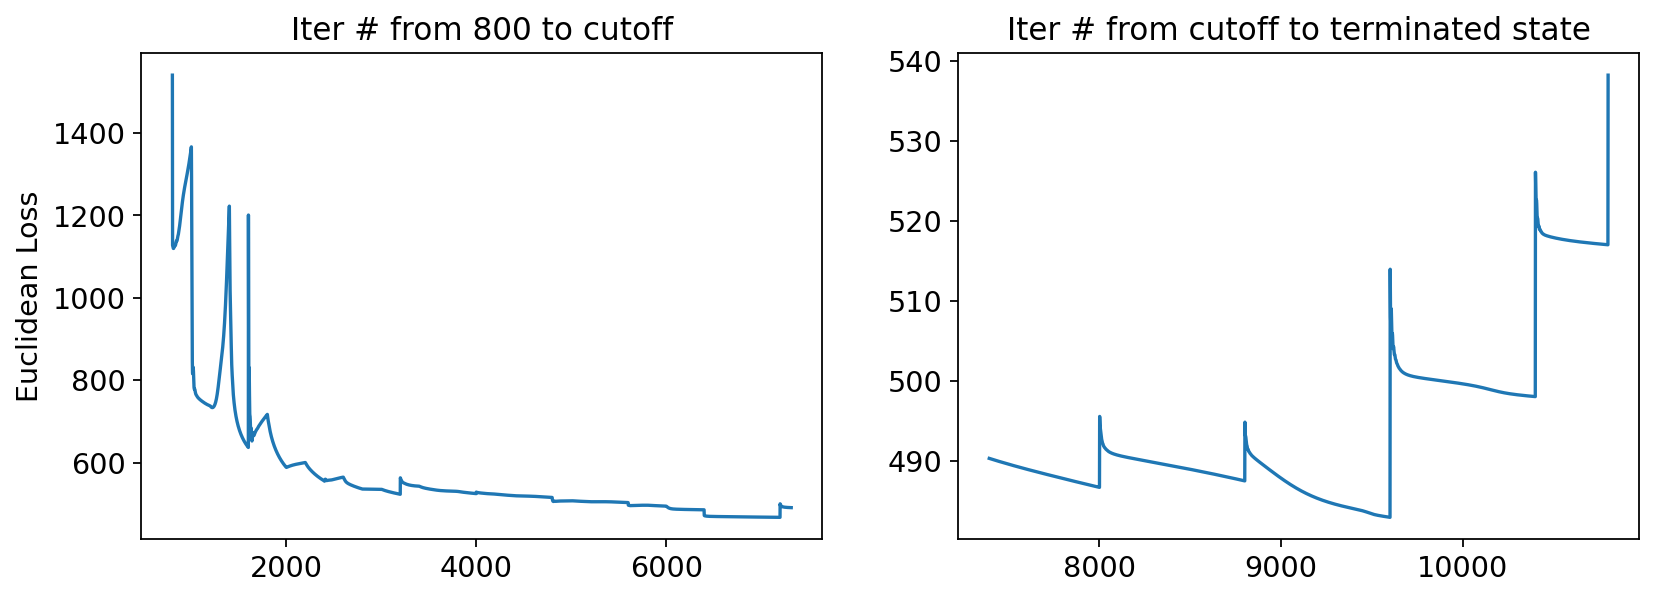

Loss (Total): 538.245, (Spliced): 263.279, (Unspliced): 274.966:  90%|█████████ | 10801/12000 [02:13<00:14, 81.11it/s]

Total loss 482.928, vgene loss 538.245


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/77 [00:00<?, ?it/s]

Detected 31 velocity genes.
Estimating the variance...


  0%|          | 0/77 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/77 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 0 to repressive
Initial induction: 47, repression: 30/77
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.020
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.5424
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1094.    *********
Change in noise variance: 0.0200
Change in x0: 1.1179
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1131.    *********
Change in noise variance: 0.0056
Change in x0: 0.5818
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1136.    *********
Change in noise variance: 0.0030
Change in x0: 0.4159
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1141.    *********
Change in noise variance: 0.0017
Change in x0: 0.3760
*********             Velocity Refinement Round 

  0%|          | 0/77 [00:00<?, ?it/s]

Detected 31 velocity genes.
Estimating the variance...


  0%|          | 0/77 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/77 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 0 to repressive
Initial induction: 47, repression: 30/77
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.027
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.5569
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.4549
Change in x0: 1.3811
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1023.    *********
Change in noise variance: 0.0654
Change in x0: 0.7074
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1031.    *********
Change in noise variance: 0.0538
Change in x0: 0.4205
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1036.    *********
Change in noise variance: 0.0051
Change in x0: 0.2587
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.80531414304458, 0.6207691137022868, 0.5542915437623316, 0.32152279183262983, 0.5445746824547251]
[0.739763539376403, 0.6488172831210174, 0.6132892313496641, 0.6521465539923994, 0.7370971772772612]
Done dataset_sim13.h5ad!
num regulators: 68
num targets: 68


  0%|          | 0/68 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.25it/s, loss=-233, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.16it/s, loss=-233, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 542/1500:  36%|███▌      | 542/1500 [02:41<05:30,  2.90it/s, loss=-72.4, v_num=1]  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1293/1500:  86%|████████▌ | 1293/1500 [06:51<01:05,  3.14it/s, loss=-144, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -242.137. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 68 highly variable genes.
Computing moments for 68 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 26 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 26 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 26 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 5195.805, (Spliced): 2453.177, (Unspliced): 2742.628:  14%|█▍        | 1680/12000 [00:18<01:41, 102.09it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 3561.977, (Spliced): 1885.950, (Unspliced): 1676.027: 100%|█████████▉| 11994/12000 [02:30<00:00, 68.25it/s]

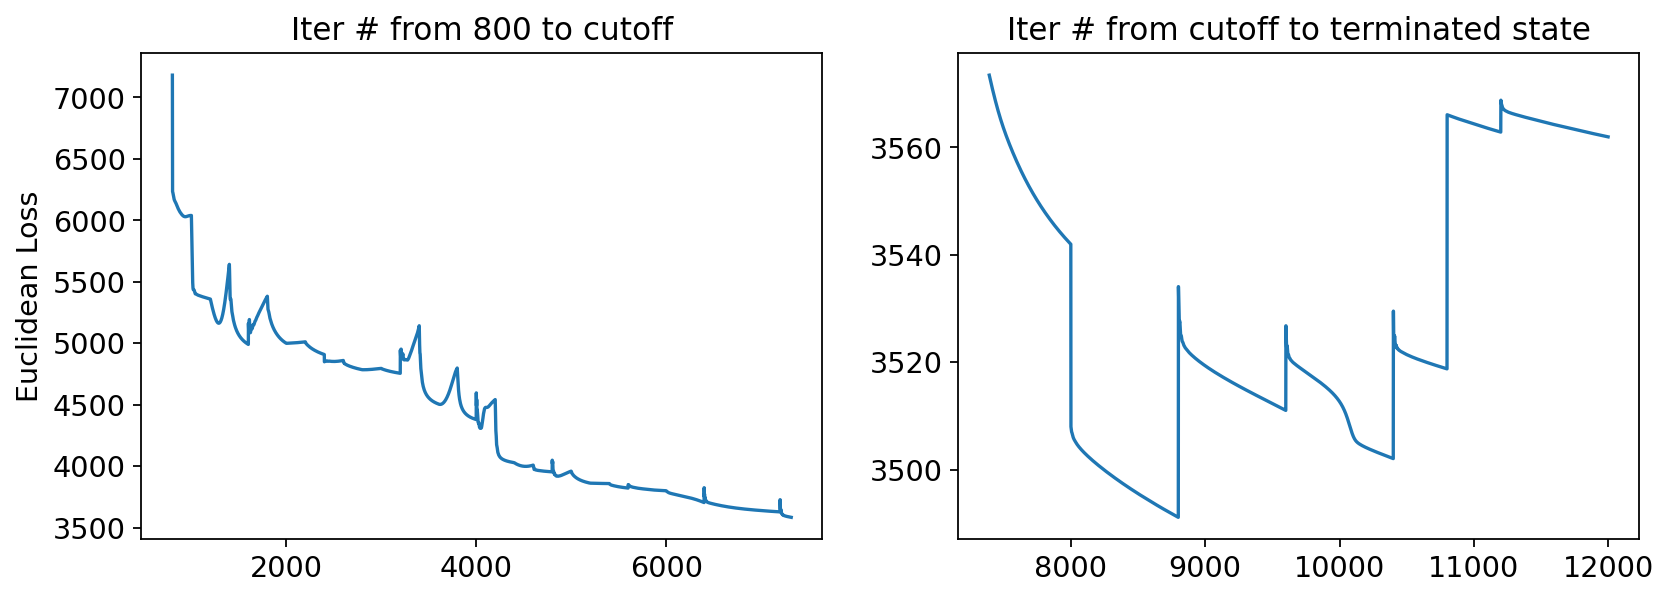

Loss (Total): 3561.977, (Spliced): 1885.950, (Unspliced): 1676.027: 100%|█████████▉| 11999/12000 [02:31<00:00, 79.29it/s]

Total loss 3491.096, vgene loss 3561.977


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/68 [00:00<?, ?it/s]

Detected 26 velocity genes.
Estimating the variance...


  0%|          | 0/68 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/68 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 1 to repressive
Initial induction: 44, repression: 24/68
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.047
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1069.    *********
Change in noise variance: 0.4445
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1158.    *********
Change in noise variance: 0.0718
Change in x0: 0.4618
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1164.    *********
Change in noise variance: 0.0633
Change in x0: 0.3434
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1169.    *********
Change in noise variance: 0.0224
Change in x0: 0.3138
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1346.    *********
Change in noise variance: 0.0220
Change in x0: 0.2809
*********             Velocity Refinement Round 

  0%|          | 0/68 [00:00<?, ?it/s]

Detected 26 velocity genes.
Estimating the variance...


  0%|          | 0/68 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/68 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 0 to repressive
Initial induction: 47, repression: 21/68
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.020
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.4306
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1203.    *********
Change in noise variance: 0.0370
Change in x0: 1.0894
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1242.    *********
Change in noise variance: 0.0046
Change in x0: 0.5468
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1248.    *********
Change in noise variance: 0.0021
Change in x0: 0.4149
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1279.    *********
Change in noise variance: 0.0011
Change in x0: 0.3386
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8474359410927209, 0.7116914374823237, 0.6281545843529961, 0.33276850267538516, 0.4364440124653986]
[0.8153553102940007, 0.7366077309454365, 0.6949541488433049, 0.6620817355135182, 0.6797307833951123]
Done dataset_sim30.h5ad!
num regulators: 50
num targets: 50


  0%|          | 0/50 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 21.99it/s, loss=-176, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.60it/s, loss=-176, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 175/1500:  12%|█▏        | 174/1500 [00:43<06:33,  3.37it/s, loss=57.1, v_num=1]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



*********       Stage 1: Early Stop Triggered at epoch 576.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 908.    *********
Change in noise variance: 0.0825
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1090.    *********
Change in noise variance: 0.0037
Change in x0: 0.1950
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1210.    *********
Change in noise variance: 0.0012
Change in x0: 0.1736
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1367.    *********
Change in noise variance: 0.0017
Change in x0: 0.1904
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1372.    *********
Change in noise variance: 0.0006
Change in x0: 0.2074
*********             Velocity Refinement Round 6

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8221364002482424, 0.7305186525247738, 0.717358884977762, 0.4077254585491993, 0.5245892485452873]
[0.7875448925294383, 0.7471096346882955, 0.7474795177035245, 0.6468382448465829, 0.7093750120080295]
Done dataset_sim27.h5ad!
num regulators: 75
num targets: 75


  0%|          | 0/75 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.51it/s, loss=-264, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:24<00:00, 20.40it/s, loss=-264, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1232/1500:  82%|████████▏ | 1232/1500 [06:30<01:24,  3.16it/s, loss=-169, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -265.344. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 75 highly variable genes.
Computing moments for 75 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 31 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 31 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 31 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 11520.282, (Spliced): 5603.622, (Unspliced): 5916.659: 100%|█████████▉| 11993/12000 [02:33<00:00, 64.30it/s] 

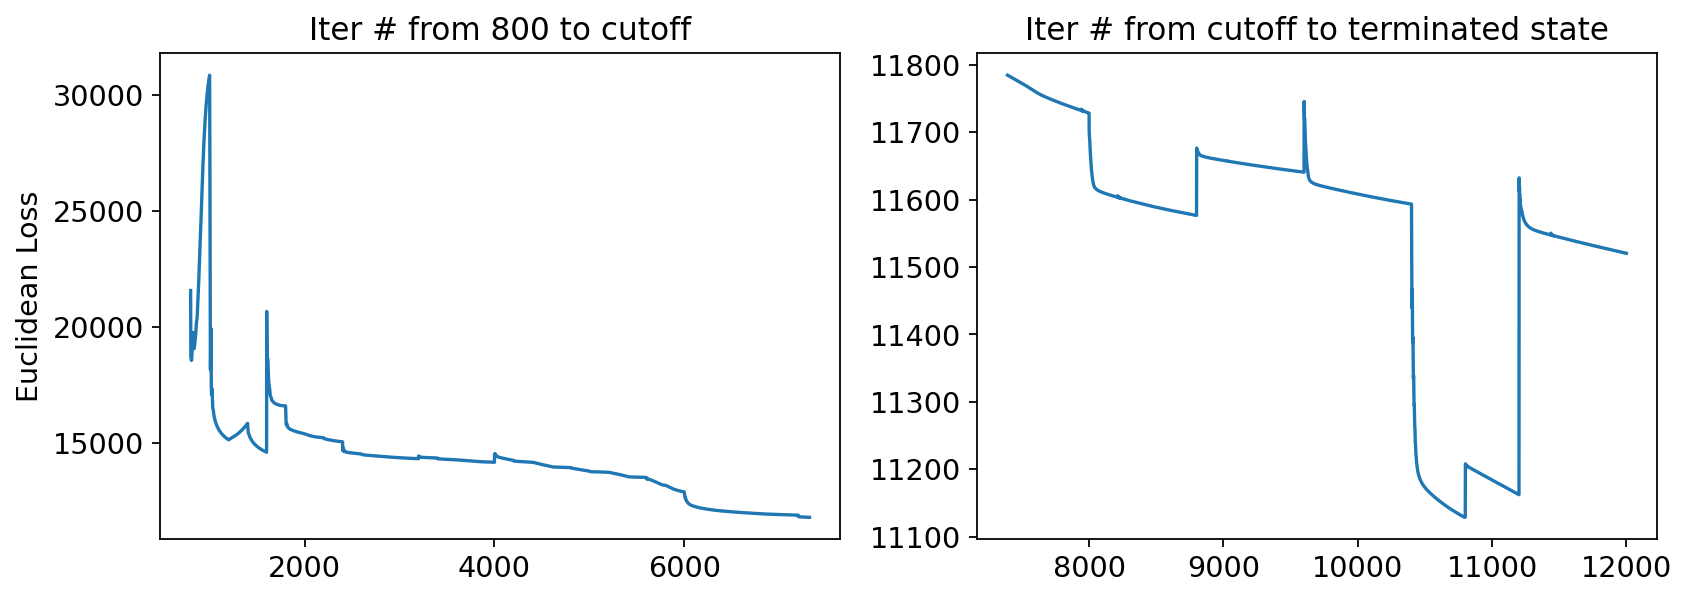

Loss (Total): 11520.282, (Spliced): 5603.622, (Unspliced): 5916.659: 100%|█████████▉| 11999/12000 [02:33<00:00, 77.96it/s]

Total loss 11128.515, vgene loss 11520.282


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/75 [00:00<?, ?it/s]

Detected 31 velocity genes.
Estimating the variance...


  0%|          | 0/75 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/75 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.67, 0.8742305593799815), (0.33, 0.19719169718970792)
KS-test result: [1. 0. 1.]
Initial induction: 63, repression: 12/75
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 624.       *********
*********                      Stage  2                       *********
*********             Velocity Refine

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.007
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 629.    *********
Change in noise variance: 1.0532
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 676.    *********
Change in noise variance: 0.2460
Change in x0: 0.7470
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 682.    *********
Change in noise variance: 0.0086
Change in x0: 0.2577
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 688.    *********
Change in noise variance: 0.0013
Change in x0: 0.0772
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 694.    *********
Change in noise variance: 0.0002
Change in x0: 0.0535
*********             Velocity Refinement Round 6    

  0%|          | 0/75 [00:00<?, ?it/s]

Detected 31 velocity genes.
Estimating the variance...


  0%|          | 0/75 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/75 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 1.]
Assign cluster 2 to repressive
Initial induction: 50, repression: 25/75
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********       Stage 1: Early Stop Triggered at epoch 584.       *********
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             

  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.040
Average Set Size: 17
*********     Round 1: Early Stop Triggered at epoch 1002.    *********
Change in noise variance: 0.7425
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1031.    *********
Change in noise variance: 0.0209
Change in x0: 0.3275
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1158.    *********
Change in noise variance: 0.0029
Change in x0: 0.2091
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1277.    *********
Change in noise variance: 0.0018
Change in x0: 0.1474
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1304.    *********
Change in noise variance: 0.0011
Change in x0: 0.1285
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8176001776879409, 0.6687747845918133, 0.6166292241388485, 0.36847940531476336, 0.5286586519054233]
[0.8168503387982117, 0.7384736186012235, 0.7028684951436281, 0.7048492209821776, 0.763355873986459]
Done dataset_sim16.h5ad!
num regulators: 130
num targets: 130


  0%|          | 0/130 [00:00<?, ?gene/s]

  0%|          | 0/1000 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 457/500:  91%|█████████▏| 457/500 [00:39<00:03, 11.47it/s, loss=-521, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -509.955. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 467/1500:  31%|███       | 466/1500 [02:43<06:37,  2.60it/s, loss=-150, v_num=1]  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)




# of velocity genes 75 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 75 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 75 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 778.299, (Spliced): 406.848, (Unspliced): 371.451:  66%|██████▋   | 7969/12000 [02:26<01:23, 48.47it/s] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



*********     Round 5: Early Stop Triggered at epoch 2207.    *********
Change in noise variance: 0.0003
Change in x0: 0.1280
*********             Velocity Refinement Round 6             *********
*********     Round 6: Early Stop Triggered at epoch 2406.    *********
Change in noise variance: 0.0000
Change in x0: 0.1078
*********             Velocity Refinement Round 7             *********
*********     Round 7: Early Stop Triggered at epoch 2583.    *********
Change in noise variance: 0.0000
Change in x0: 0.0963
*********             Velocity Refinement Round 8             *********
Change in noise variance: 0.0000
Change in x0: 0.0866
*********             Velocity Refinement Round 9             *********
Stage 2: Early Stop Triggered at round 8.
*********              Finished. Total Time =   0 h :  4 m : 38 s             *********
Final: Train ELBO = 106.972,	Test ELBO = 90.139


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.8771476954483285, 0.7444547733721484, 0.557755965844001, 0.4882250221797997, 0.6681973633428762]
[0.7802284516128908, 0.7073040435036123, 0.6225174346694833, 0.6166105210686215, 0.7697627108085082]
Done dataset_sim5_new.h5ad!
num regulators: 95
num targets: 95


  0%|          | 0/95 [00:00<?, ?gene/s]

  0%|          | 0/1000 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:44<00:00, 11.33it/s, loss=-389, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:44<00:00, 11.30it/s, loss=-389, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 971/1500:  65%|██████▍   | 971/1500 [05:44<03:07,  2.82it/s, loss=-187, v_num=1]  
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -290.473. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 94 highly variable genes.
Computing moments for 94 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 45 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 45 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 45 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 3469.960, (Spliced): 1783.539, (Unspliced): 1686.421: 100%|█████████▉| 11996/12000 [03:30<00:00, 47.47it/s] 

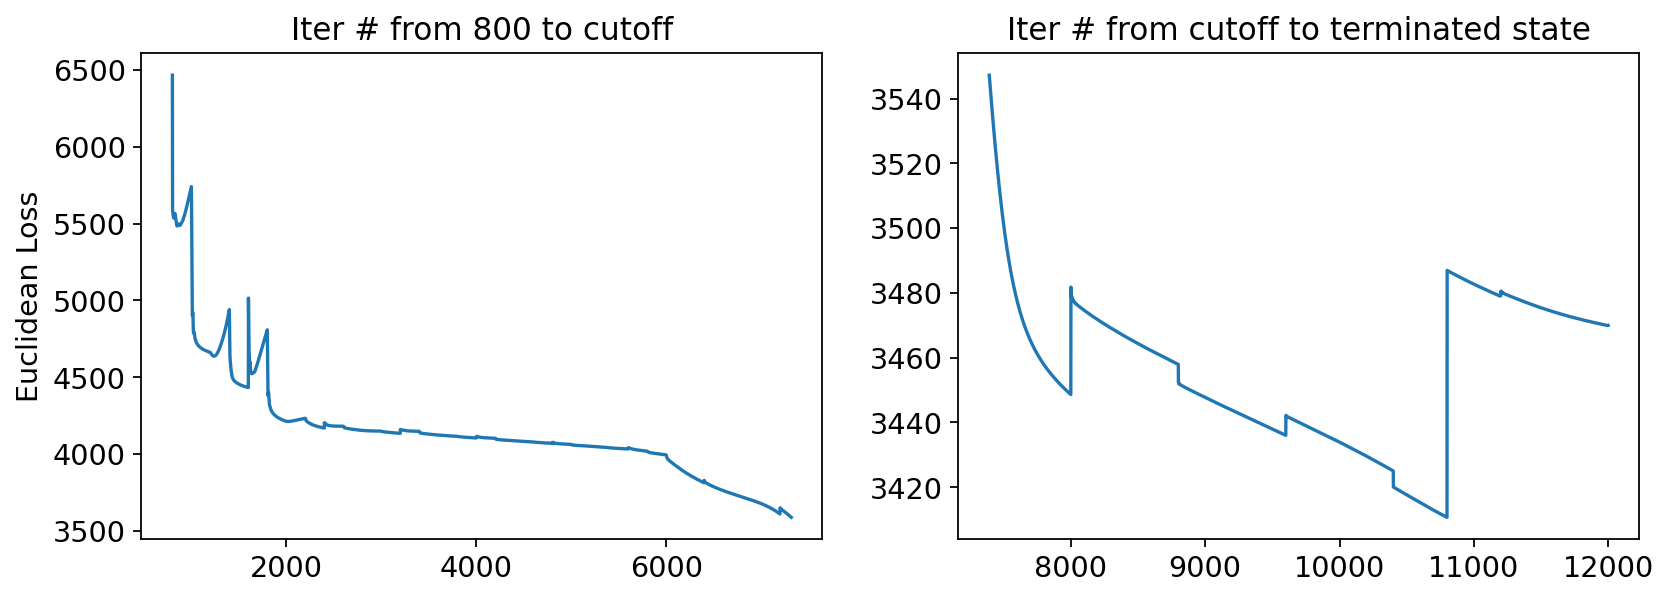

Loss (Total): 3469.960, (Spliced): 1783.539, (Unspliced): 1686.421: 100%|█████████▉| 11999/12000 [03:31<00:00, 56.86it/s]

Total loss 3410.720, vgene loss 3469.960


  0%|          | 0/1000 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/94 [00:00<?, ?it/s]

Detected 46 velocity genes.
Estimating the variance...


  0%|          | 0/94 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/94 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.60, 0.31899996136382497), (0.40, 0.8696148341928387)
KS-test result: [0. 1. 1.]
Initial induction: 69, repression: 25/94
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 6, test iteration: 10
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.030
Average Set Size: 20
*********     Round 1: Early Stop Triggered at epoch 1209.    *********
Change in noise variance: 0.3759
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1348.    *********
Change in noise variance: 0.0166
Change in x0: 0.4327
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1527.    *********
Change in noise variance: 0.0048
Change in x0: 0.3314
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1536.    *********
Change in noise variance: 0.0012
Change in x0: 0.2176
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1648.    *********
Change in noise variance: 0.0007
Change in x0: 0.1868
*********             Velocity Refinement Round 

  0%|          | 0/94 [00:00<?, ?it/s]

Detected 45 velocity genes.
Estimating the variance...


  0%|          | 0/94 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/94 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
(0.52, 0.2668820568274643), (0.48, 0.8298862523672441)
KS-test result: [0. 1. 1.]
Initial induction: 71, repression: 23/94
Learning Rate based on Data Sparsity: 0.0001
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 6, test iteration: 10
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/1000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.033
Average Set Size: 19
*********     Round 1: Early Stop Triggered at epoch 1457.    *********
Change in noise variance: 0.3551
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1624.    *********
Change in noise variance: 0.0222
Change in x0: 0.4504
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1711.    *********
Change in noise variance: 0.0045
Change in x0: 0.3583
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1747.    *********
Change in noise variance: 0.0006
Change in x0: 0.2808
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1758.    *********
Change in noise variance: 0.0000
Change in x0: 0.2535
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7637677307945874, 0.6794790866334938, 0.6344621983032667, 0.42399215359858805, 0.6037440550416973]
[0.8061330411483095, 0.7869197286137686, 0.7401256185249122, 0.7180292373456484, 0.7927451489108585]
Done dataset_sim4_new.h5ad!
num regulators: 81
num targets: 81


  0%|          | 0/81 [00:00<?, ?gene/s]

  0%|          | 0/300 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 187/500:  37%|███▋      | 187/500 [00:09<00:15, 20.12it/s, loss=-201, v_num=1]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 20.02it/s, loss=-271, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:25<00:00, 19.90it/s, loss=-271, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1155/1500:  77%|███████▋  | 1155/1500 [05:56<01:46,  3.24it/s, loss=-191, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -299.912. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 81 highly variable genes.
Computing moments for 81 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 29 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 29 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 29 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 135592.905, (Spliced): 68018.767, (Unspliced): 67574.138:  46%|████▌     | 5536/12000 [01:02<01:12, 88.88it/s]    IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 1208/1500:  81%|████████  | 1208/1500 [05:59<01:27,  3.36it/s, loss=-110, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -207.040. Signaling Trainer to stop.
------> Manully Specified Parameters <------
GPU:	-1
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 62 highly variable genes.
Computing moments for 62 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 26 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 26 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 26 (Criterion: genes have reads in more than 5% of total cells)
No GPU device has been detected. Switch to CPU mode.


Loss (Total): 692.428, (Spliced): 327.628, (Unspliced): 364.799:  71%|███████▏  | 8567/12000 [01:37<00:42, 80.29it/s]]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Loss (Total): 9828401542.095, (Spliced): 4997668083.810, (Unspliced): 4830733458.286:  67%|██████▋   | 7999/12000 [01:31<00:58, 68.03it/s]   

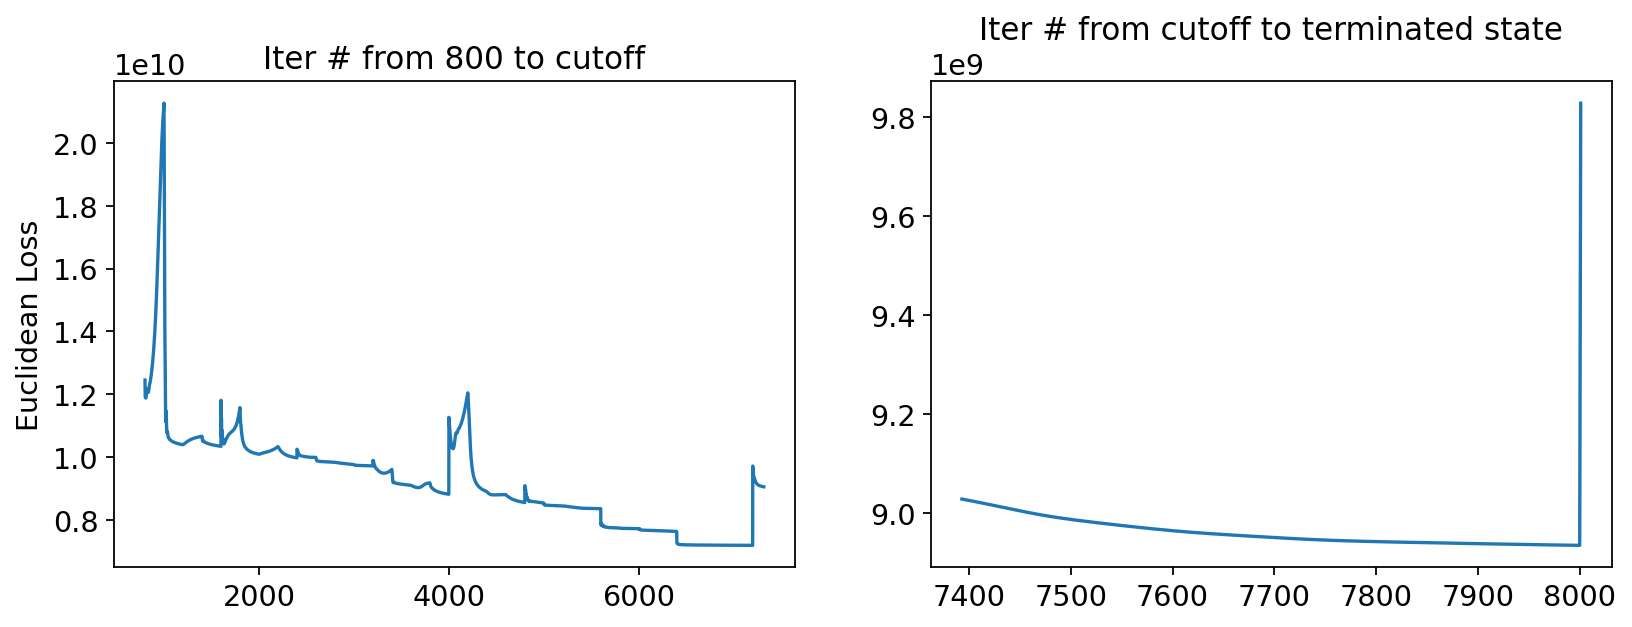

Loss (Total): 9828401542.095, (Spliced): 4997668083.810, (Unspliced): 4830733458.286:  67%|██████▋   | 8001/12000 [01:32<00:46, 86.62it/s]

Total loss 8934249423.238, vgene loss 9828401542.095


  0%|          | 0/300 [00:00<?, ?cells/s]

Estimating ODE parameters...


  0%|          | 0/71 [00:00<?, ?it/s]

Detected 24 velocity genes.
Estimating the variance...


  0%|          | 0/71 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/71 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [2. 1. 1.]
Initial induction: 48, repression: 23/71
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.090
Average Set Size: 16
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.0367
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0060
Change in x0: 0.5384
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1147.    *********
Change in noise variance: 0.0014
Change in x0: 0.4778
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1152.    *********
Change in noise variance: 0.0004
Change in x0: 0.3521
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1157.    *********
Change in noise variance: 0.0000
Change in x0: 0.2595
*********             Velocity Refinement Round 

  0%|          | 0/71 [00:00<?, ?it/s]

Detected 25 velocity genes.
Estimating the variance...


  0%|          | 0/71 [00:00<?, ?it/s]

Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/71 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [2. 1. 2.]
Initial induction: 31, repression: 40/71
Learning Rate based on Data Sparsity: 0.0000
--------------------------- Train a VeloVAE ---------------------------
Embedding not found! Set to None.
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 2, test iteration: 2
*********                      Stage  2                       *********
*********             Velocity Refinement Round 1             *********


  0%|          | 0/300 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.090
Average Set Size: 15
*********     Round 1: Early Stop Triggered at epoch 1006.    *********
Change in noise variance: 0.0364
*********             Velocity Refinement Round 2             *********
*********     Round 2: Early Stop Triggered at epoch 1012.    *********
Change in noise variance: 0.0073
Change in x0: 0.5311
*********             Velocity Refinement Round 3             *********
*********     Round 3: Early Stop Triggered at epoch 1132.    *********
Change in noise variance: 0.0020
Change in x0: 0.3999
*********             Velocity Refinement Round 4             *********
*********     Round 4: Early Stop Triggered at epoch 1137.    *********
Change in noise variance: 0.0007
Change in x0: 0.3545
*********             Velocity Refinement Round 5             *********
*********     Round 5: Early Stop Triggered at epoch 1194.    *********
Change in noise variance: 0.0000
Change in x0: 0.2935
*********             Velocity Refinement Round 

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is cell type specific GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
Input is global GRN...
[0.7948464248172769, 0.6613084860261904, 0.6097575025032065, 0.4341312154471842, 0.4960718856600689]
[0.740237355197209, 0.6835759777787289, 0.661599384560893, 0.7138122780268592, 0.7188072471579153]
Done dataset_sim28.h5ad!
num regulators: 72
num targets: 72


  0%|          | 0/72 [00:00<?, ?gene/s]

  0%|          | 0/200 [00:00<?, ?cells/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:15<00:00, 32.91it/s, loss=-192, v_num=1] 

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:15<00:00, 33.27it/s, loss=-192, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 553/1500:  37%|███▋      | 552/1500 [02:43<05:23,  2.93it/s, loss=-87.5, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
for adata_name in files:
    address = os.getcwd() + '/RegVelo_datasets/dyngen_simulation/' + adata_name
    
    adata = sc.read_h5ad(address)
    adata_raw = adata.copy()
    csgn = csgn_groundtruth(adata)
    adata.uns["csgn"] = csgn

    adata.X = adata.X.copy()
    adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
    adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()


    scv.pp.filter_and_normalize(adata, min_shared_counts=10)
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
    scv.pp.moments(adata)
    #scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    adata.X = np.log1p(adata.X.copy())


    sc.tl.leiden(adata)
    adata_raw.obs["cluster"] = adata.obs["leiden"].copy()
    adata_raw.obsm["X_pca"] = adata.obsm["X_pca"].copy()
    adata_raw.layers["spliced"] = adata_raw.layers["counts_spliced"].copy()
    adata_raw.layers["unspliced"] = adata_raw.layers["counts_unspliced"].copy()


    adata = preprocess_data(adata,filter_on_r2 = True)
    adata = sanity_check(adata,network_mode="full_ODE")
    adata.uns["Ms"] = adata.layers["Ms"]
    adata.uns["Mu"] = adata.layers["Mu"]


    ## save raw data
    adata_raw.var["highly_variable"] = [adata_raw.var.index[i] in adata.var.index for i in range(adata_raw.shape[1])]
    adata_raw = adata_raw[:,adata_raw.var["highly_variable"]]
    save_address = "data_file_" + adata_name
    save_address = DATA_DIR / 'simulation' / 'dyngen_results' / 'copy_file' / save_address
    adata_raw.write(save_address)
    
    ## Run scVelo model (dynamical)
    scv.tl.recover_dynamics(
            adata, fit_scaling=False, var_names=adata.var_names, n_jobs=1
        )
    adata.var["fit_scaling"] = 1.0
    adata.layers["fit_t_dynamical"] = adata.layers["fit_t"].copy()
    scv.tl.velocity(adata, mode="dynamical", min_likelihood=-np.inf, min_r2=None)
    scv.tl.latent_time(adata,min_likelihood=None)

    velocity_gt = adata.layers["rna_velocity"]
    velocity = adata.layers["velocity"]
    dim = velocity.shape[1]
    
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

    corr = np.array(corr)[:,0]
    dynamical_corr = corr


    ## Run scVelo model (stochastic)
    scv.tl.velocity(adata, mode="stochastic")
    velocity_gt = adata.layers["rna_velocity"]
    velocity = adata.layers["velocity"]
    dim = velocity.shape[1]
    
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))
        
    corr = np.array(corr)[:,0]
    stochastic_corr = corr


    ## Run scVelo model (deterministic)
    scv.tl.velocity(adata, mode="deterministic")
    velocity_gt = adata.layers["rna_velocity"]
    velocity = adata.layers["velocity"]
    dim = velocity.shape[1]
    
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

    corr = np.array(corr)[:,0]
    deterministic_corr = corr

    ### fit VeloVI
    torch.cuda.empty_cache()
    VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
    vae = VELOVI(adata)
    vae.train()
    add_velovi_outputs_to_adata(adata, vae)


    velocity_gt = adata.layers["rna_velocity"]
    velocity = adata.layers["velocity"]
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))
        #corr.append(calculate_sign_ratio(np.sign(np.array(velocity_gt.todense()[:,i]).ravel()), np.sign(np.array(velocity[:,i]).ravel())))

    corr = np.array(corr)[:,0]
    velovi_corr = corr

    
    ### Run RegVelo
    W = adata.uns["skeleton"].copy()
    GRN_gt = adata.uns["skeleton"].copy()
    W = torch.tensor(np.array(W)).int()
    W = torch.ones(W.shape)

    """
    intersection = list(set(adata.uns["regulators"]).intersection(adata.uns["targets"]))
    for i in intersection:
        index1 = [j == i for j in adata.uns["regulators"]]
        index2 = [j == i for j in adata.uns["targets"]]
        W[index1,index2] = 0
    """
    
    torch.cuda.empty_cache()
    REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
    reg_vae = REGVELOVI(adata,W=W,t_max = 20)
    reg_vae.train()

    adata_target = add_regvelo_outputs_to_adata(adata, reg_vae)
   

    velocity_gt = adata_target.layers["rna_velocity"]
    velocity = adata_target.layers["velocity"]
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))
        #corr.append(calculate_sign_ratio(np.sign(np.array(velocity_gt.todense()[:,i]).ravel()), np.sign(np.array(velocity[:,i]).ravel())))

    corr = np.array(corr)[:,0]
    regvelo_corr = corr

    Jaco_m = GRN_Jacobian(reg_vae,adata.layers["Ms"])


    # calculate unitvelo
    velo = utv.config.Configuration()
    velo.GPU = -1
    velo.FIT_OPTION = '1'
    adata_utv = utv.run_model(str(save_address), "cluster", config_file=velo)
    
    dim = adata.shape[1]
    velocity_gt = adata_utv.layers["rna_velocity"]
    velocity = adata_utv.layers["velocity"]

    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

    corr = np.array(corr)[:,0]
    unitvelo_corr = corr


    ## calculate veloVAE
    adata_vv = adata_utv.copy()
    vae = vv.VAE(adata_vv, 
                 tmax=20, 
                 dim_z=10, 
                 device='cuda:0')

    config = {
        # You can change any hyperparameters here!
    }
    vae.train(adata_vv,
              config=config,
              plot=False,
              embed='dimred')
    
    # In[130]:
    file_name = adata_name+"_sim_vae.h5ad"
    vae.save_anndata(adata_vv, 'vae', "GRN_benchmark", file_name=file_name)

    ## calculate veloVAE(VAE)
    velocity_gt = adata_vv.layers["rna_velocity"]
    velocity = adata_vv.layers["vae_velocity"]
    
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))

    vae_corr = np.array(corr)[:,0]
    
    ###################
    try:
        # Perform some computation in f(a)
        rate_prior = {
        'alpha': (0, 1.0),
        'beta': (0, 0.5),
        'gamma': (0, 0.5)
        }
        full_vb = vv.VAE(adata_vv, 
                         tmax=20, 
                         dim_z=10, 
                         device='cuda:0',
                         full_vb=True,
                         rate_prior=rate_prior)
        
        
        config = {
            # You can change any hyperparameters here!
        }
        full_vb.train(adata_vv,
                  config=config,
                  plot=False,
                  embed='dimred')
        
        file_name = adata_name + "_sim_fullvb.h5ad"
        full_vb.save_anndata(adata_vv, 'fullvb', "GRN_benchmark", file_name=file_name)
    
    
        velocity_gt = adata_vv.layers["rna_velocity"]
        velocity = adata_vv.layers["fullvb_velocity"]
    
        corr = []
        for i in range(velocity.shape[1]):
            corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:,i]).ravel(), np.array(velocity[:,i]).ravel()))
    
        fullvb_corr = np.array(corr)[:,0]
        # If no error is raised, break the loop and return the result
    except:
        # If an error is raised, increment a and try again, and need to recompute double knock-out reults
        fullvb_corr = [np.nan] * len(vae_corr)

    
    # Done velocity!
    # calculate correlation
    regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
    target_index = [i in adata.uns["targets"] for i in adata.var.index.values]

    corr_m = 1 - cdist(adata.layers["Ms"].T, adata.layers["Ms"].T, metric='correlation')
    corr_m = torch.tensor(corr_m)
    corr_m = corr_m[target_index,]
    corr_m = corr_m[:,regulator_index]
    corr_m = corr_m.float()


    GRN = torch.mean(Jaco_m,2)


    GRN_weight = reg_vae.module.v_encoder.fc1.weight.detach()

    ### Run GRNBoost2 to benchmark the GRN inference performance
    GEP = pd.DataFrame(adata.layers["Ms"],columns = adata.var.index.values)
    local_cluster = LocalCluster()
    client = Client(local_cluster)
    network = grnboost2(expression_data=GEP,
                        tf_names=adata.uns["regulators"],
                        client_or_address=client)
    
    client.close()
    local_cluster.close()
    
    ind = [i in adata.uns["targets"] for i in network["target"]]
    network = network[ind]


    grnboost_m = np.zeros((len(adata.uns["targets"]),len(adata.uns["regulators"])))
    grnboost_m = pd.DataFrame(grnboost_m,index = adata.uns["targets"], columns = adata.uns["regulators"])
    for i in adata.uns["targets"]:
        for j in adata.uns["regulators"]:
            ind = (network["TF"] == j) & (network["target"] == i)
            if sum(ind) > 0:
                pdd = network[ind]
                grnboost_m.loc[i,j] = pdd["importance"].values


    Jaco_m = Jaco_m.cpu().detach()
    GRN = GRN.cpu().detach()
    GRN_weight = GRN_weight.cpu().detach()


    score = csgn_benchmark2(torch.abs(Jaco_m),GRN_gt,adata.uns["csgn"])
    score2 = csgn_benchmark2(torch.abs(GRN),GRN_gt,adata.uns["csgn"])
    score3 = csgn_benchmark2(torch.abs(GRN_weight),GRN_gt,adata.uns["csgn"])
    score4 = csgn_benchmark2(torch.abs(corr_m),GRN_gt,adata.uns["csgn"])
    score5 = csgn_benchmark2(torch.tensor(np.array(grnboost_m)),GRN_gt,adata.uns["csgn"])
    
    score_all = csgn_benchmark2(torch.abs(Jaco_m),W,adata.uns["csgn"])
    score2_all = csgn_benchmark2(torch.abs(GRN),W,adata.uns["csgn"])
    score3_all = csgn_benchmark2(torch.abs(GRN_weight),W,adata.uns["csgn"])
    score4_all = csgn_benchmark2(torch.abs(corr_m),W,adata.uns["csgn"])
    score5_all = csgn_benchmark2(torch.tensor(np.array(grnboost_m)),W,adata.uns["csgn"])

    ### Visualize the Violin Plots
    AUROC = [np.mean(score), np.mean(score2), np.mean(score3), np.mean(score4), np.mean(score5)]
    AUROC_all = [np.mean(score_all), np.mean(score2_all), np.mean(score3_all), np.mean(score4_all), np.mean(score5_all)]
    AUC_GRN_result.append(AUROC)
    AUC_GRN_result_all.append(AUROC_all)
    print(AUROC)
    print(AUROC_all)
    # In[79]:


    fit_t_dynamical = adata.layers["fit_t_dynamical"]
    fit_t_velovi = adata.layers["fit_t_velovi"]
    fit_t_regvelo = adata_target.layers["fit_t"]


    ## gene specific latent time correlation with ground truth
    velocity = adata_target.layers["velocity"]
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.spearmanr(fit_t_dynamical[:,i], adata_target.obs["sim_time"]))

    corr = np.array(corr)[:,0]
    corr_latent_time_dynamical = corr


    velocity = adata_target.layers["velocity"]
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.spearmanr(fit_t_velovi[:,i], adata_target.obs["sim_time"]))

    corr = np.array(corr)[:,0]
    corr_latent_time_velovi = corr


    velocity = adata_target.layers["velocity"]
    corr = []
    for i in range(velocity.shape[1]):
        corr.append(scipy.stats.spearmanr(fit_t_regvelo[:,i], adata_target.obs["sim_time"]))

    corr = np.array(corr)[:,0]
    corr_latent_time_regvelo = corr

    
    ## outputs

    gene_time_corr_res = [np.mean(corr_latent_time_dynamical),np.mean(corr_latent_time_velovi),np.mean(corr_latent_time_regvelo)]

    ## calculate velocity correlation
    gene_velo_corr_res = [np.mean(dynamical_corr),np.mean(deterministic_corr),np.mean(stochastic_corr),np.mean(velovi_corr),np.mean(regvelo_corr),np.mean(unitvelo_corr),np.mean(fullvb_corr),np.mean(vae_corr)]
    
    gene_time_corr_all.append(gene_time_corr_res)
    gene_velo_corr_all.append(gene_velo_corr_res)
    
    df = pd.DataFrame(gene_velo_corr_all)
    df.columns = ["dynamical","deterministic","stochastic","velovi","regvelo","UniTVelo","VeloVAE(fullvb)","VeloVAE(vae)"]

    if SAVE_DATASETS:
        df.to_csv(DATA_DIR / 'simulation' / 'dyngen_results' /  'gene_velo_corr_all_final_res.csv')

    df = pd.DataFrame(gene_time_corr_all)
    df.columns = ["dynamical","velovi","regvelo"]

    if SAVE_DATASETS:
        df.to_csv(DATA_DIR / 'simulation' / 'dyngen_results' /  'gene_time_corr_all_final_res.csv')
        
    df = pd.DataFrame(AUC_GRN_result)
    df.columns = ["Jaco","GRN_mean","GRN_weight","corr_m","GRNBoost2"]

    if SAVE_DATASETS:
        df.to_csv(DATA_DIR / 'simulation' / 'dyngen_results' /  'AUROC_res_all_final_res.csv')
    
    df = pd.DataFrame(AUC_GRN_result_all)
    df.columns = ["Jaco","GRN_mean","GRN_weight","corr_m","GRNBoost2"]

    if SAVE_DATASETS:
        df.to_csv(DATA_DIR / 'simulation' / 'dyngen_results' /  'AUROC_res_all_full_final_res.csv')
        
    print("Done " + adata_name + "!")

## Plot benchmark results

### plot velocity benchmark

In [11]:
TFvelo = pd.read_csv("RegVelo_datasets/dyngen_benchmark/TFvelo_res.csv",index_col = 0)
cell2fate = pd.read_csv("RegVelo_datasets/dyngen_benchmark/c2f_velo_cor.csv",index_col = 0)

In [12]:
full_gene_velo = pd.read_csv(DATA_DIR / 'simulation' / 'dyngen_results' / "gene_velo_corr_all_final_res.csv",index_col = 0)

In [13]:
full_gene_velo.columns = ["scVelo","scVelo(deterministic)","scVelo(stochastic)","veloVI","RegVelo","UniTVelo","VeloVAE(vae)","VeloVAE(fullvb)"]

In [14]:
result_df = full_gene_velo.T
result_df.loc[:,"index"] = result_df.index
new_df = pd.melt(result_df, id_vars=['index'], value_name='Performance', var_name='Method')
new_df = new_df.iloc[:,[0,2]].copy()
new_df.columns = ["Method","Performance"]

In [15]:
new_df = new_df.append(pd.DataFrame({"Method": "TFvelo","Performance" : TFvelo["velocity_corr"]}))
new_df = new_df.append(pd.DataFrame({"Method": "cell2fate","Performance" : cell2fate.iloc[:,0]}))

In [16]:
new_df['Method'] = pd.Categorical(new_df['Method'], categories=["RegVelo","veloVI","scVelo","scVelo(stochastic)","scVelo(deterministic)","UniTVelo","VeloVAE(vae)","VeloVAE(fullvb)","TFvelo","cell2fate"])

In [17]:
new_df.loc[:,"Performance"] = (new_df.loc[:,"Performance"] + 1) / 2

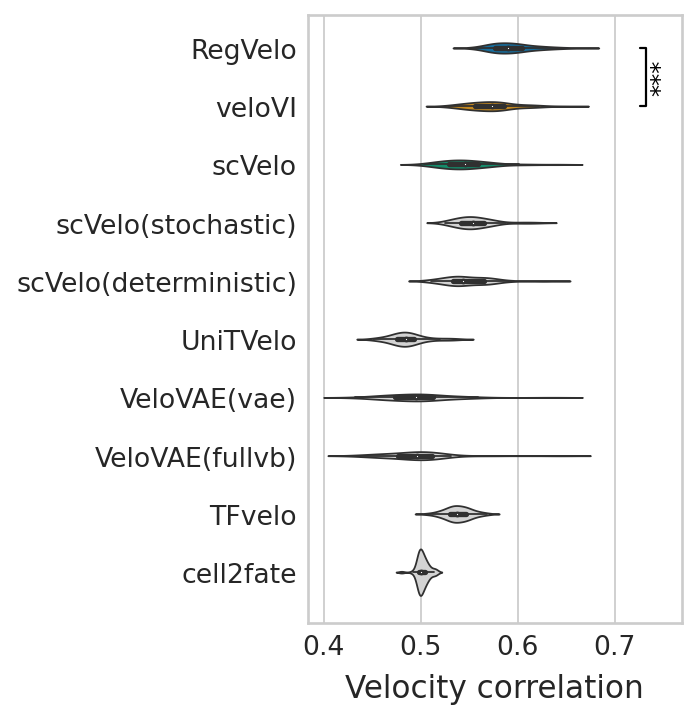

In [18]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 5))

    #sns.violinplot(data=new_df, x="Method", y="Performance", palette="colorblind", ax=ax)
    colors = sns.color_palette("colorblind", n_colors=3)
    colors = colors + ["lightgrey"]*7
    sns.violinplot(data=new_df, y="Method", x="Performance", ax=ax, palette = colors,linewidth=0.8)
    
    ttest_res = wilcoxon(new_df.iloc[:,1][new_df.iloc[:,0] == "RegVelo"].values, new_df.iloc[:,1][new_df.iloc[:,0] == "veloVI"].values, alternative="greater",)
    significance = get_significance(ttest_res.pvalue)
    add_significance2(
        ax=ax, bottom=0, top=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )


    x_min, x_max = ax.get_xlim()
    ax.set(ylabel='', xlabel='Velocity correlation')
    ax.set_xlim([x_min, x_max + 0.02])

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'simulation'/ 'dyngen_results' / 'velocity_benchmark.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()

### plot latent time benchmark

In [19]:
df = pd.read_csv(DATA_DIR / 'simulation' / 'dyngen_results' / 'gene_time_corr_all_final_res.csv',index_col = 0)

In [20]:
result = df.T
result.index = ["scVelo","veloVI","RegVelo"]
result.loc[:,"index"] = result.index
new_df = pd.melt(result, id_vars=['index'], value_name='Performance', var_name='Method')
new_df = new_df.iloc[:,[0,2]].copy()
new_df.columns = ["Method","Performance"]
new_df['Method'] = pd.Categorical(new_df['Method'], categories=["RegVelo","veloVI","scVelo"])

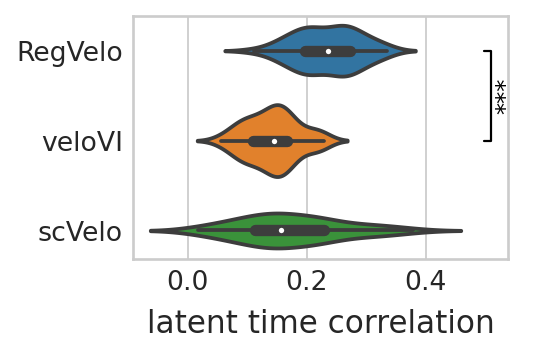

In [21]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 2))
    #pal = {"RegVelo":"#f3e1eb","veloVI":"#b5bbe3","scVelo":"#0fcfc0"}
    sns.violinplot(data=new_df, y="Method", x="Performance", ax=ax)
    
    
    ttest_res = wilcoxon(new_df.iloc[:,1][new_df.iloc[:,0] == "RegVelo"].values, new_df.iloc[:,1][new_df.iloc[:,0] == "veloVI"].values, alternative="greater",)
    significance = get_significance(ttest_res.pvalue)
    add_significance2(
        ax=ax, bottom=0, top=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )
    

    y_min, y_max = ax.get_ylim()
    ax.set(ylabel='', xlabel='latent time correlation')
    ax.set_ylim([y_min, y_max + 0.02])
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'simulation'/ 'dyngen_results' / 'latent_time_benchmark.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()

### GRN inference benchmark

In [22]:
df_co = pd.read_csv("RegVelo_datasets/dyngen_benchmark/AUROC_res_all_celloracle.csv",index_col = 0)
df_spliceJAC = pd.read_csv("RegVelo_datasets/dyngen_benchmark/AUROC_res_all_spliceAJ.csv",index_col = 0)

In [23]:
df = pd.read_csv(DATA_DIR / 'simulation' / 'dyngen_results' / 'AUROC_res_all_full_final_res.csv',index_col = 0)

In [24]:
df.shape

(50, 5)

In [25]:
performance = df.iloc[:,0].tolist() + df.iloc[:,3].tolist() + df.iloc[:,4].tolist() + df_co.iloc[:,0].tolist() + df_spliceJAC.iloc[:,0].tolist() + TFvelo.iloc[:,0].tolist()
method = ["RegVelo"] * len(df.iloc[:,0].tolist()) + ["Cor"] * len(df.iloc[:,0].tolist()) + ["GRNBoost2"] * len(df.iloc[:,0].tolist()) + ["CellOracle"] * len(df_co.iloc[:,0].tolist()) + ["spliceJAC"] * len(df_spliceJAC.iloc[:,0].tolist()) + ["TFvelo"] * TFvelo.shape[0]

In [26]:
new_df = pd.DataFrame({"Method": method, "Performance": performance})
new_df = new_df.loc[~np.isnan(new_df.iloc[:,1]),:].copy()

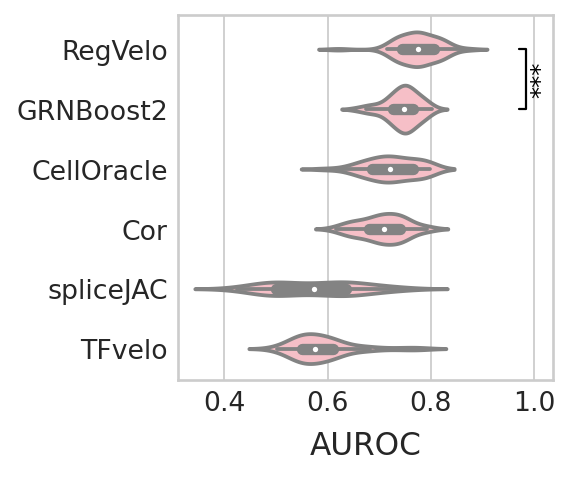

In [28]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3,3))

    #sns.violinplot(data=result, x="Method", y="Performance", palette="colorblind",order = ["RegVelo","GRNBoost2","CellOracle","Cor","spliceJAC"], ax=ax)
    sns.violinplot(data=new_df, y="Method", x="Performance", color = "lightpink",order = ["RegVelo","GRNBoost2","CellOracle","Cor","spliceJAC","TFvelo"], ax=ax)
    
    ttest_res = wilcoxon(new_df.iloc[:,1][new_df.iloc[:,0] == "RegVelo"].values, new_df.iloc[:,1][new_df.iloc[:,0] == "GRNBoost2"].values, alternative="greater",)
    significance = get_significance(ttest_res.pvalue)
    add_significance2(
        ax=ax, bottom=0, top=1, significance=significance, lw=1, bracket_level=1.05, c="k", level=0,
    )


    x_min, x_max = ax.get_xlim()
    ax.set(ylabel='', xlabel='AUROC')
    ax.set_xlim([x_min, x_max + 0.02])
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / 'simulation'/ 'dyngen_results' / 'GRN_benchmark.svg',
            format="svg",
            transparent=True,
            bbox_inches='tight'
        )
    plt.show()